SQL QUERY:  
select limit_balance, CAST(sex AS INT64) as sex, CAST(education_level AS INT64) as education_level, CAST(marital_status AS INT64) as marital_status, age, pay_0, pay_2, pay_3, pay_4, CAST(pay_5 AS FLOAT64) as pay_5, CAST(pay_6 AS FLOAT64) as pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS INT64) as default_payment_next_month
from bigquery-public-data.ml_datasets.credit_card_default
limit 33949

# Perkenalan

## Perkenalan Diri

Nama : Edwin Reyhan Devara Ramadhan Rasya  
Batch : FTDS-017-RMT

## Pengenalan Dataset

Dataset yang dipakai pada P1M1 ini berupa 24 features dan 2965 rows. Dataset ini diperuntukkan untuk melakukan klasifikasi apakah nasabah pengguna kartu kredit akan default atau tidak. Features dataset ini terdiri dari data-data penting nasabah seperti limit balance kredit mereka, sudah berapa bulan mereka menunggak, bill amount, dll.

## Objective

Penyedia kartu kredit ingin melakukan kehati-hatian dalam menyetujui pengajuan kartu kredit calon nasabah mereka. 
Mereka tidak ingin rugi hanya kerena mereka tidak mengetahui karakteristik calon nasabah yang akan default.
Oleh karena itu, kita akan melakukan prediksi klasifikasi apakah nasabah akan default atau tidak berdasarkan data history nasabah mereka yang sudah default dan tidak.
Untuk menekan angka kemungkinan kita menerima calon nasabah yang akan default, kita akan berforkus pada angka False Negative. 
Kita ingin angka False Negative ini sekecil mungkin untuk menghindari salah melakukan klasifikasi atau menyetujui calon nasabah yang memiliki karakteristik akan default. 
Tujuan untuk menekan angka False Negative juga bisa dilakukan dengan berfokus pada memiliki metric Recall yang bagus (besar).   

Problem      : Klasifikasi nasabah akan default atau tidak  
Fokus Metric : False Negative atau Recall

>---

# Importing Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pylab
import pickle
import json
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from scipy.stats.mstats import winsorize 

>---

# Data Loading

In [2]:
# Loading data with read_csv
data_raw = pd.read_csv('h8dsft_P1M1_Edwin_Reyhan_Devara_Ramadhan_Rasya.csv')

In [3]:
# view the first 10 rows
data_raw.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
3,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
4,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0
5,500000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,152365.0,139757.0,153348.0,20000.0,20241.0,20154.0,20019.0,20151.0,20037.0,0
6,50000.0,1,2,1,40.0,0.0,0.0,0.0,0.0,0.0,...,44356.0,19344.0,19354.0,1691.0,1942.0,1296.0,674.0,693.0,1000.0,0
7,100000.0,1,5,1,45.0,0.0,0.0,0.0,0.0,0.0,...,90500.0,82586.0,22620.0,5000.0,5000.0,3203.0,2103.0,50000.0,0.0,0
8,140000.0,1,2,1,29.0,0.0,0.0,0.0,0.0,0.0,...,132038.0,131961.0,124256.0,6696.0,5000.0,4866.0,5300.0,5055.0,5000.0,0
9,50000.0,1,2,1,43.0,0.0,0.0,0.0,0.0,0.0,...,48934.0,29116.0,28999.0,1800.0,2200.0,1400.0,582.0,580.0,30000.0,0


In [4]:
# view the last 10 rows
data_raw.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,300000.0,2,2,1,28.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,1000.0,16666.0,0.0,0.0,0.0,0.0,0
2956,200000.0,2,1,1,49.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,225.0,0
2957,50000.0,2,1,2,31.0,-1.0,0.0,-1.0,-1.0,-1.0,...,3995.0,0.0,0.0,30018.0,12787.0,3995.0,0.0,0.0,0.0,0
2958,50000.0,2,1,2,25.0,-1.0,-1.0,2.0,-1.0,-1.0,...,10610.0,0.0,0.0,5000.0,200.0,10610.0,0.0,0.0,0.0,0
2959,100000.0,2,1,2,37.0,-1.0,-1.0,0.0,-1.0,-1.0,...,780.0,0.0,0.0,21711.0,1000.0,780.0,0.0,0.0,0.0,0
2960,30000.0,2,3,2,50.0,-1.0,-1.0,2.0,-1.0,-1.0,...,1110.0,0.0,0.0,1860.0,0.0,1110.0,0.0,0.0,0.0,1
2961,20000.0,2,1,2,25.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,640.0,0.0,0.0,0.0,855.0,640.0,0.0,0.0,2742.0,0
2962,280000.0,2,1,2,52.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,930.0,0.0,0.0,0.0,0.0,0
2963,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2964,100000.0,2,1,2,30.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,35993.0,2772.0,0.0,0.0,0.0,0.0,0


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Semua features memiliki type numerical. Features di atas akan kita lihat lebih lanjut di step selanjutnya yaitu EDA.

>---

# EDA

In [6]:
# copy the raw data for EDA purpose only
data_eda = data_raw.copy()

## Check which features are categorical or numerical

In [7]:
# findout which features are numerical in python and determine are they truly numerical features
data_eda.select_dtypes(include=np.number).head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
1,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0.0,...,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
2,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
3,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
4,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


sex, marital_status, default_payment_next_month adalah categorical nominal columns  
sedangkan education_level adalah categorical ordinal column  
dan lainnya adalah numerical columns

## Check Distribution of Numerical Features

### Check target column distribution

In [8]:
data_eda.default_payment_next_month.value_counts() / len(data_eda)

0    0.785835
1    0.214165
Name: default_payment_next_month, dtype: float64

79% kolom target diisi oleh kelas 0 (tidak default), sedangkan 21% lainnya diisi oleh kelas 1 (default)

### limit_balance

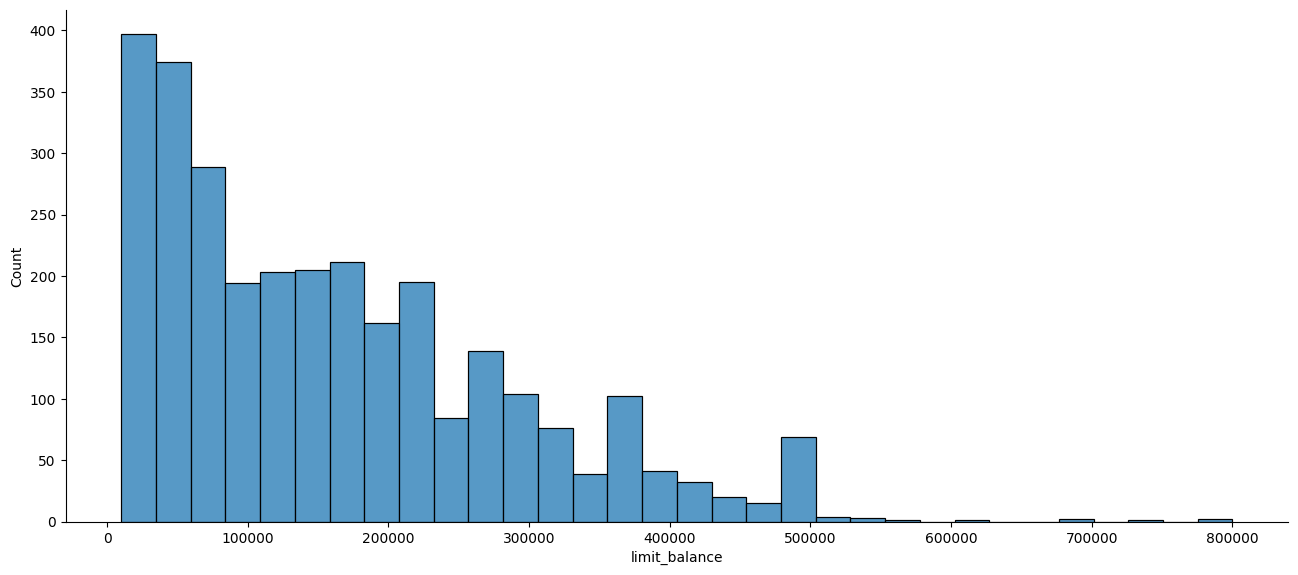

In [9]:
# check distribusi limit_balance
fig=sns.displot(x='limit_balance', data=data_eda)
fig.fig.set_size_inches(15,6)

Mayoritas nasabah kredit card memiliki limit_balance yang tidak lebih dari 500.000 NT. Namun ada beberapa nasabah yang memiliki limit_balance lebih dari 500.000 sampai 800.000

### umur

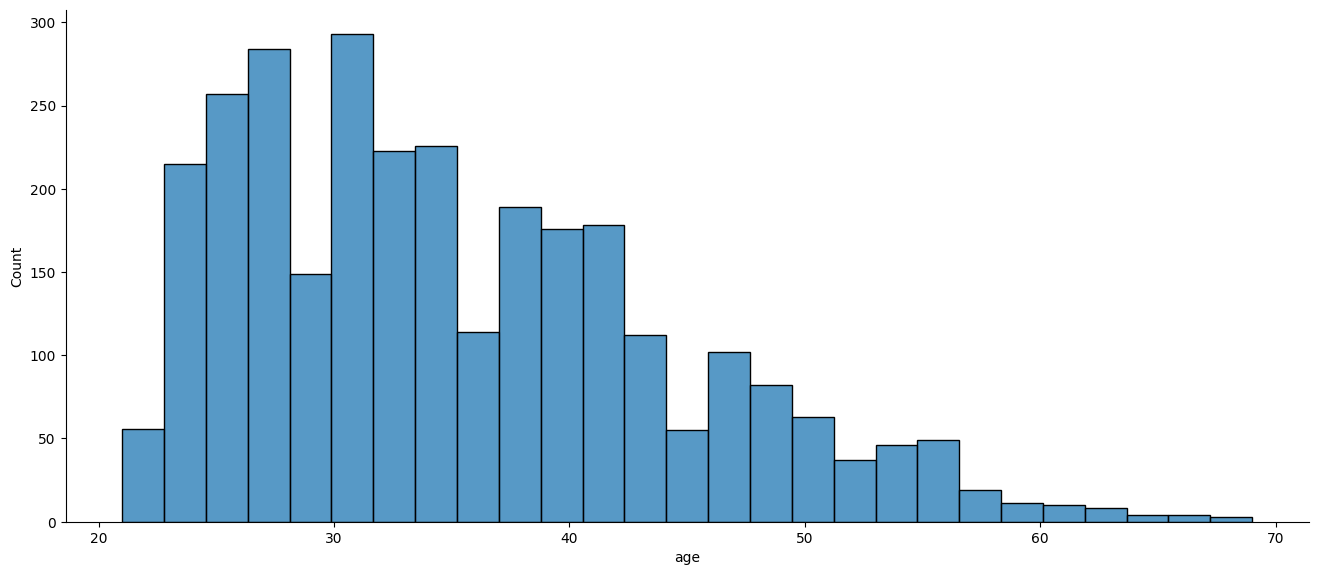

In [10]:
# check distribusi age
fig=sns.displot(x='age', data=data_eda)
fig.fig.set_size_inches(15,6)

Range umur para nasabah pemakai kartu kredit adalah 20-an sampai 70.

### pay_ features

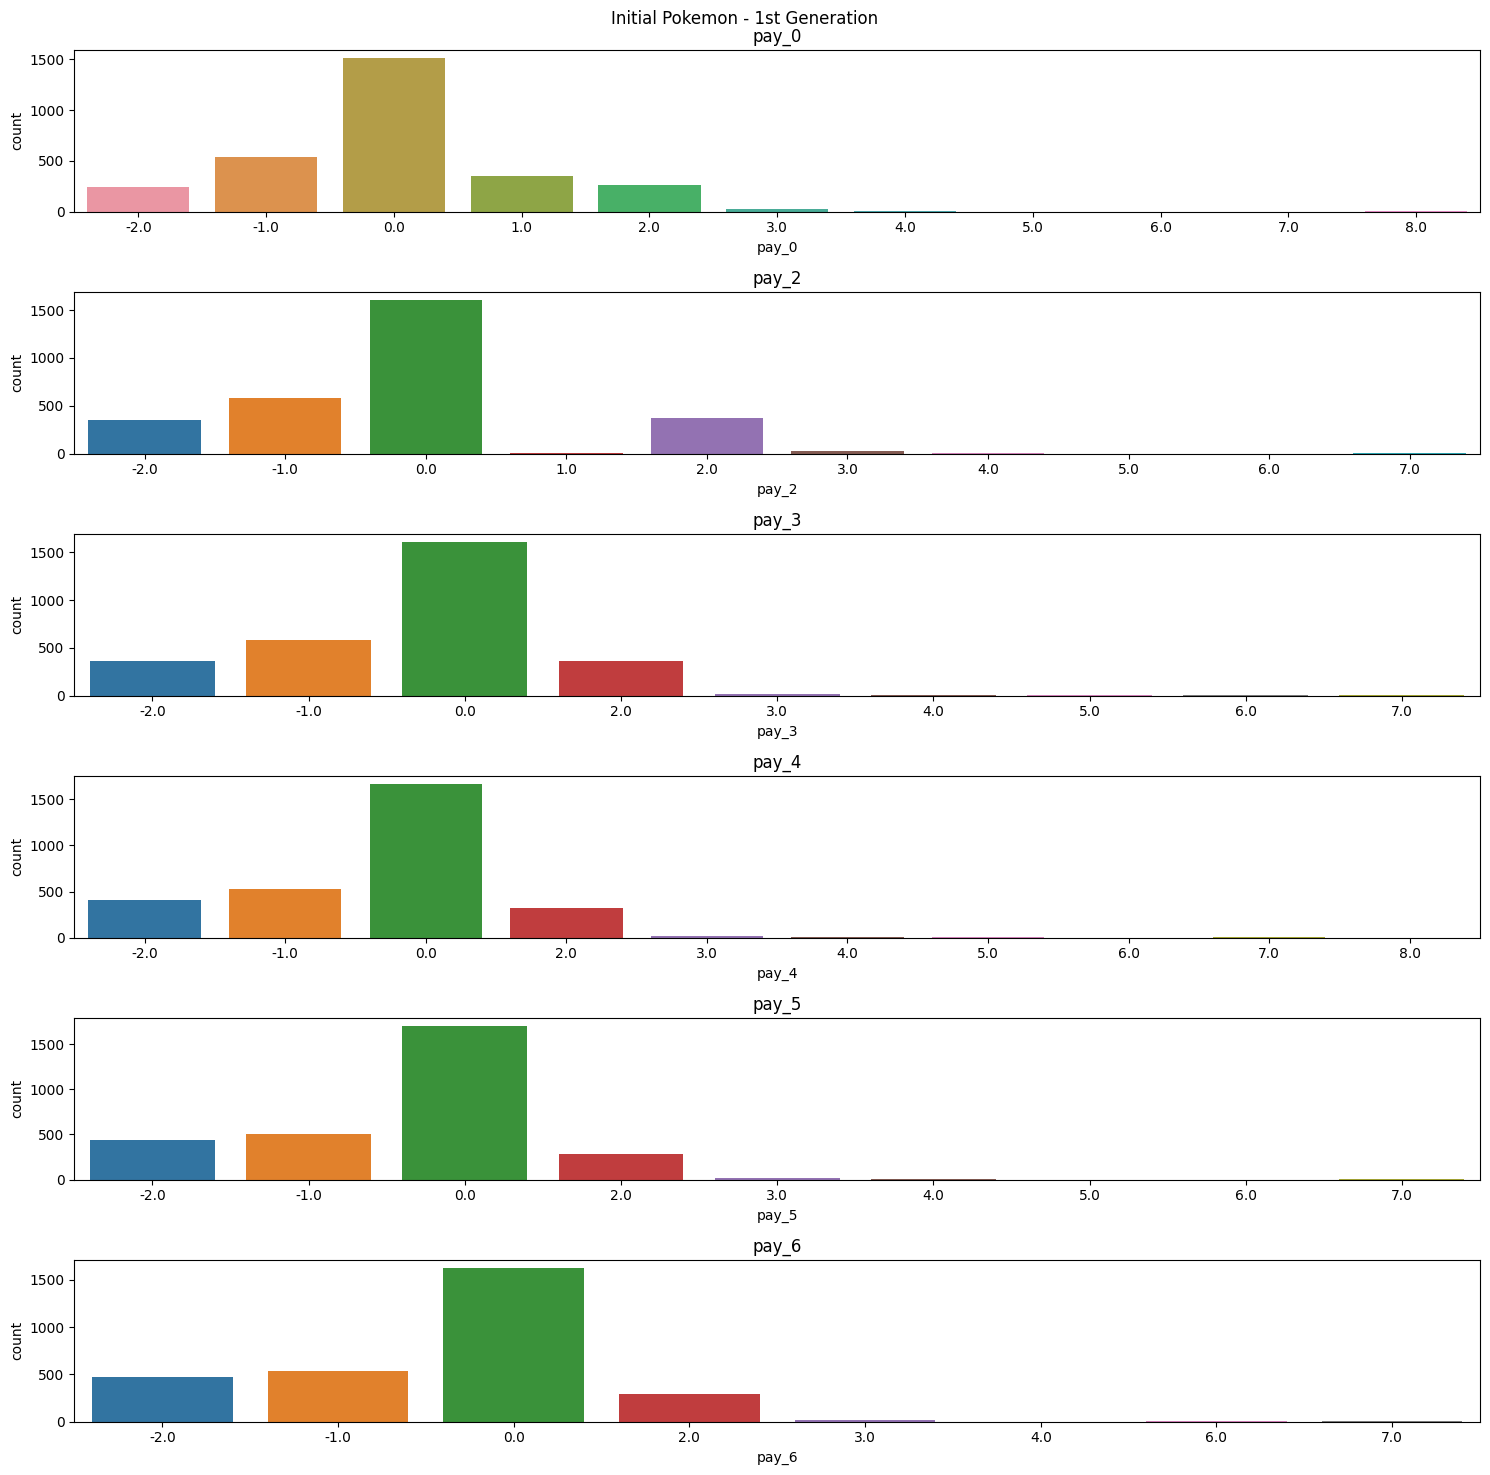

In [11]:
fig, axes = plt.subplots(6, 1, figsize=(15, 15))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.countplot(ax=axes[0], x=data_eda.pay_0)
axes[0].set_title('pay_0')

sns.countplot(ax=axes[1], x=data_eda.pay_2)
axes[1].set_title('pay_2')

sns.countplot(ax=axes[2], x=data_eda.pay_3)
axes[2].set_title('pay_3')

sns.countplot(ax=axes[3], x=data_eda.pay_4)
axes[3].set_title('pay_4')

sns.countplot(ax=axes[4], x=data_eda.pay_5)
axes[4].set_title('pay_5')

sns.countplot(ax=axes[5], x=data_eda.pay_6)
axes[5].set_title('pay_6')

fig.tight_layout()

pay_0, pay_2, pay_3, pay_4, pay_5, pay_6 adalah categorical features. Mereka menunjukkan berapa jumlah uang yang dianggap sebagai pinjaman. semua features tersebut memiliki modus 0, yang menunjukkan bahwa kebanyakan orang memakai kartu kredit dengan rajin membayar dan rajin juga memakai. sedangkat kita juga melihat ada outliers (jumlah sangat sedikit) di sisi kanan feature-feature tersebut. sisi kanan menunjukkan bahwa mereka sudah menunggak pembayaran berapa bulan, misal mereka ada di x=6, berarti mereka nuggak 6 bulan.

### bill_amt_ features

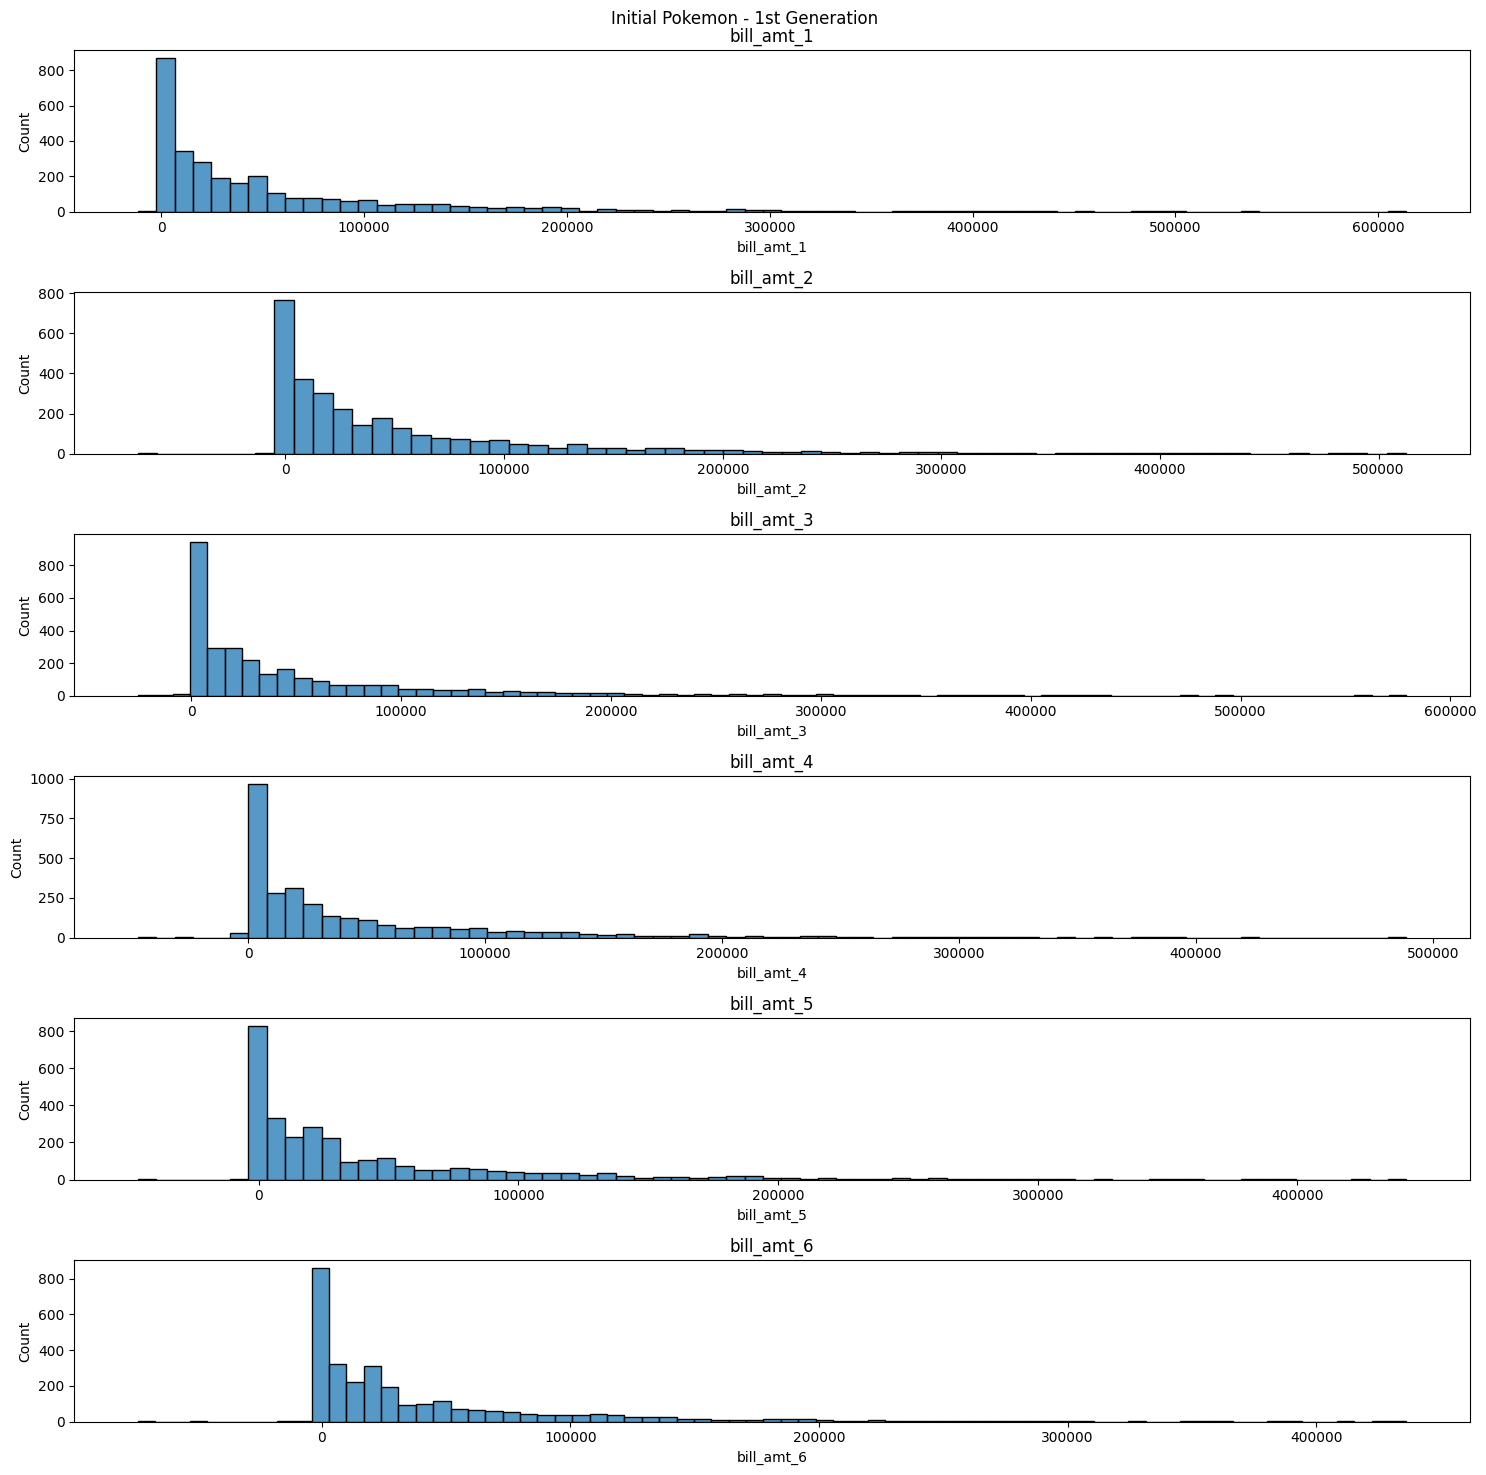

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(15, 15))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.histplot(ax=axes[0], x=data_eda.bill_amt_1)
axes[0].set_title('bill_amt_1')

sns.histplot(ax=axes[1], x=data_eda.bill_amt_2)
axes[1].set_title('bill_amt_2')

sns.histplot(ax=axes[2], x=data_eda.bill_amt_3)
axes[2].set_title('bill_amt_3')

sns.histplot(ax=axes[3], x=data_eda.bill_amt_4)
axes[3].set_title('bill_amt_4')

sns.histplot(ax=axes[4], x=data_eda.bill_amt_5)
axes[4].set_title('bill_amt_5')

sns.histplot(ax=axes[5], x=data_eda.bill_amt_6)
axes[5].set_title('bill_amt_6')

fig.tight_layout()

pada features bill_amt_ , kita bisa melihat bahwa nasabah banyak menggunakan credit card dengan jumlah transaksi 0-200.000 per bulan yang mana mereka harus bayarkan ketika billing cycle berakhir. Kita juga bisa melihat bahwa ada beberapa orang yang memakai atau meminjam uang sampai 300.000 lebih, bahkan ada yang 600.000 lebih.

### pay_amt_ features

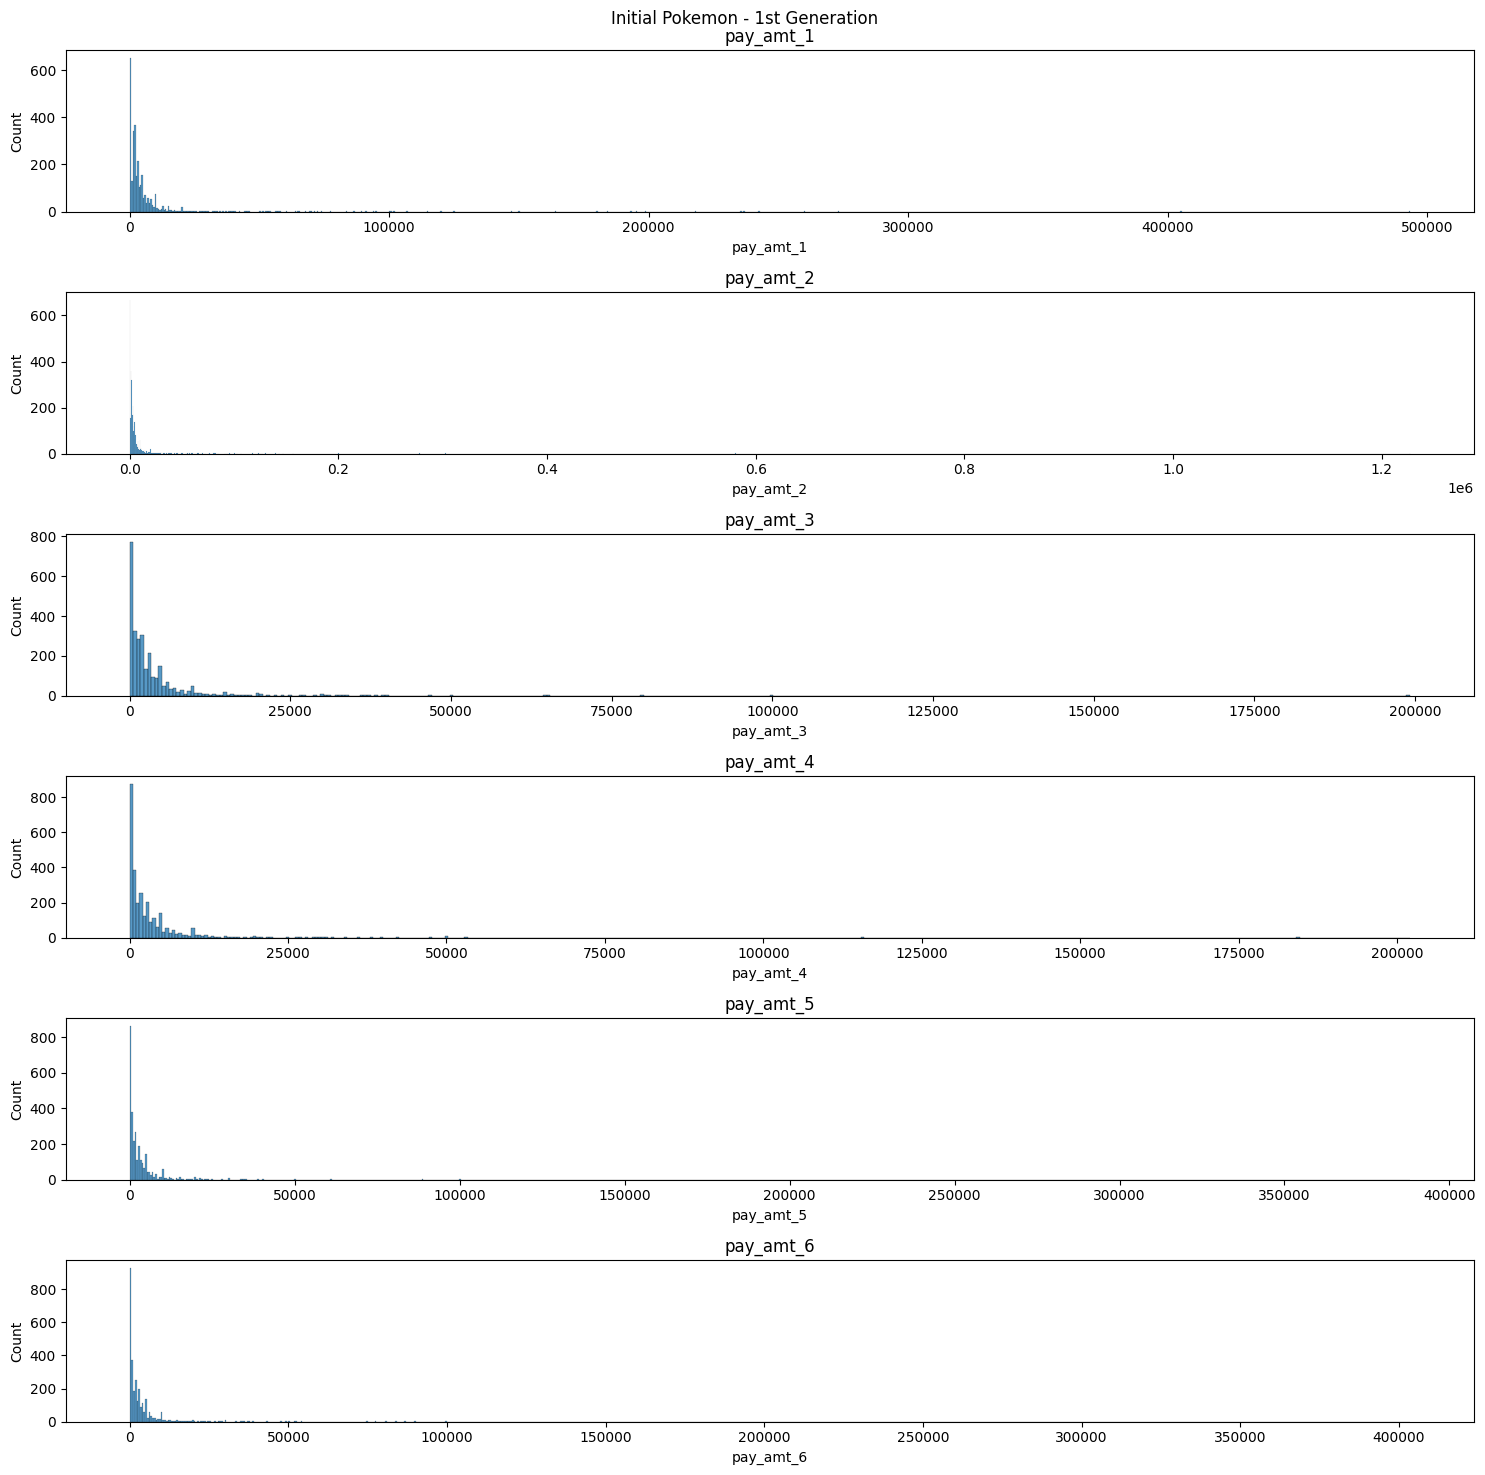

In [13]:
fig, axes = plt.subplots(6, 1, figsize=(15, 15))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.histplot(ax=axes[0], x=data_eda.pay_amt_1)
axes[0].set_title('pay_amt_1')

sns.histplot(ax=axes[1], x=data_eda.pay_amt_2)
axes[1].set_title('pay_amt_2')

sns.histplot(ax=axes[2], x=data_eda.pay_amt_3)
axes[2].set_title('pay_amt_3')

sns.histplot(ax=axes[3], x=data_eda.pay_amt_4)
axes[3].set_title('pay_amt_4')

sns.histplot(ax=axes[4], x=data_eda.pay_amt_5)
axes[4].set_title('pay_amt_5')

sns.histplot(ax=axes[5], x=data_eda.pay_amt_6)
axes[5].set_title('pay_amt_6')

fig.tight_layout()

features pay_amt_ memberikan informasi mengenai biaya-biaya atau juga amount yang ada sejak terakhil kali bayar yang dimasukkan ke current bill. Kebanyak nasabah memiliki previous payment atau balance yang sedikit yaitu 0 sampai kurang lebih 20.000. Sedangkat kita juga bisa melihat bahwa ada beberapa nasabah yang memiliki previous balance sangat besar.

## Per feature dan target

In [14]:
data_eda.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

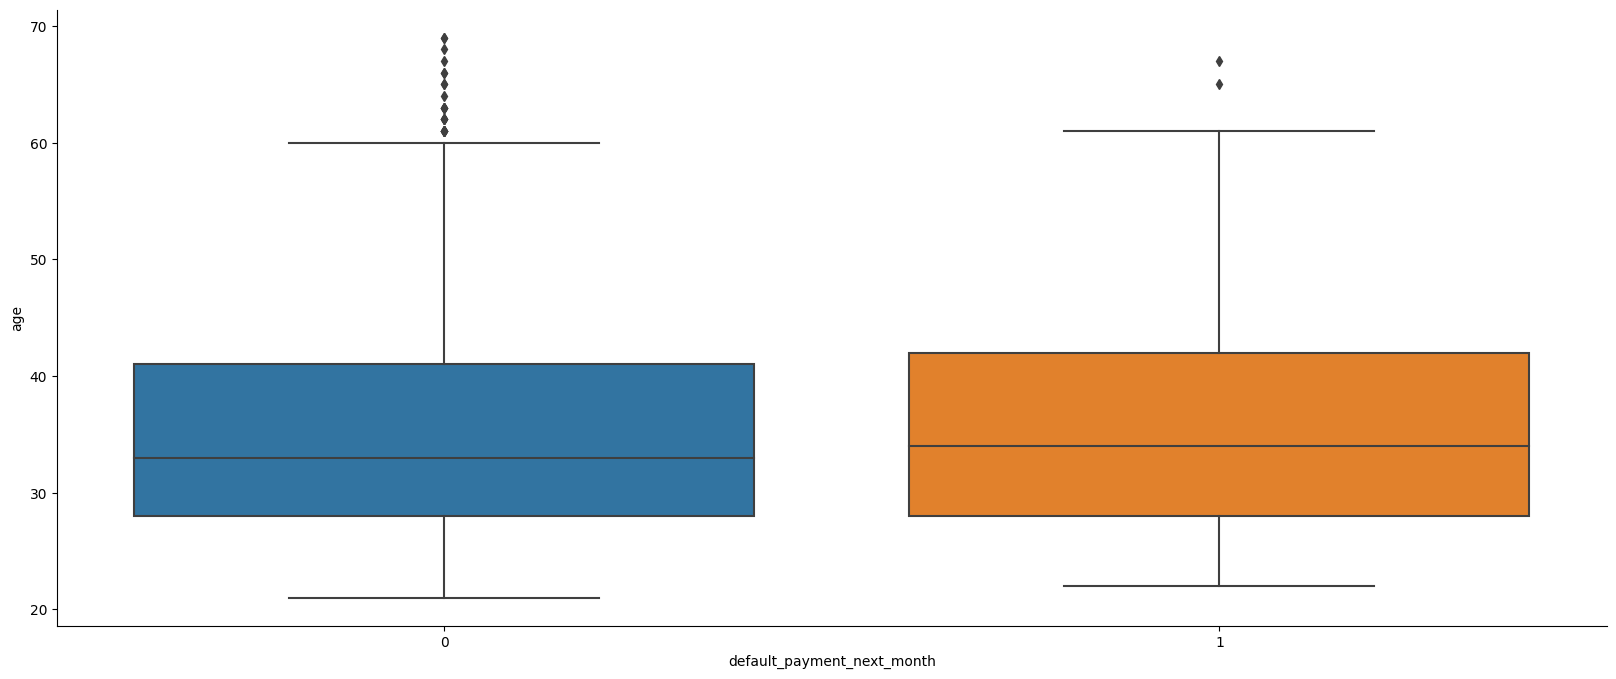

In [15]:
# check age per label di target
f, ax = plt.subplots(figsize=(20, 8))
sns.despine(f)
sns.boxplot(x='default_payment_next_month', y='age', data=data_eda);

Sepertinya age tidak mempengaruhi apakah kita akan default atau tidak.

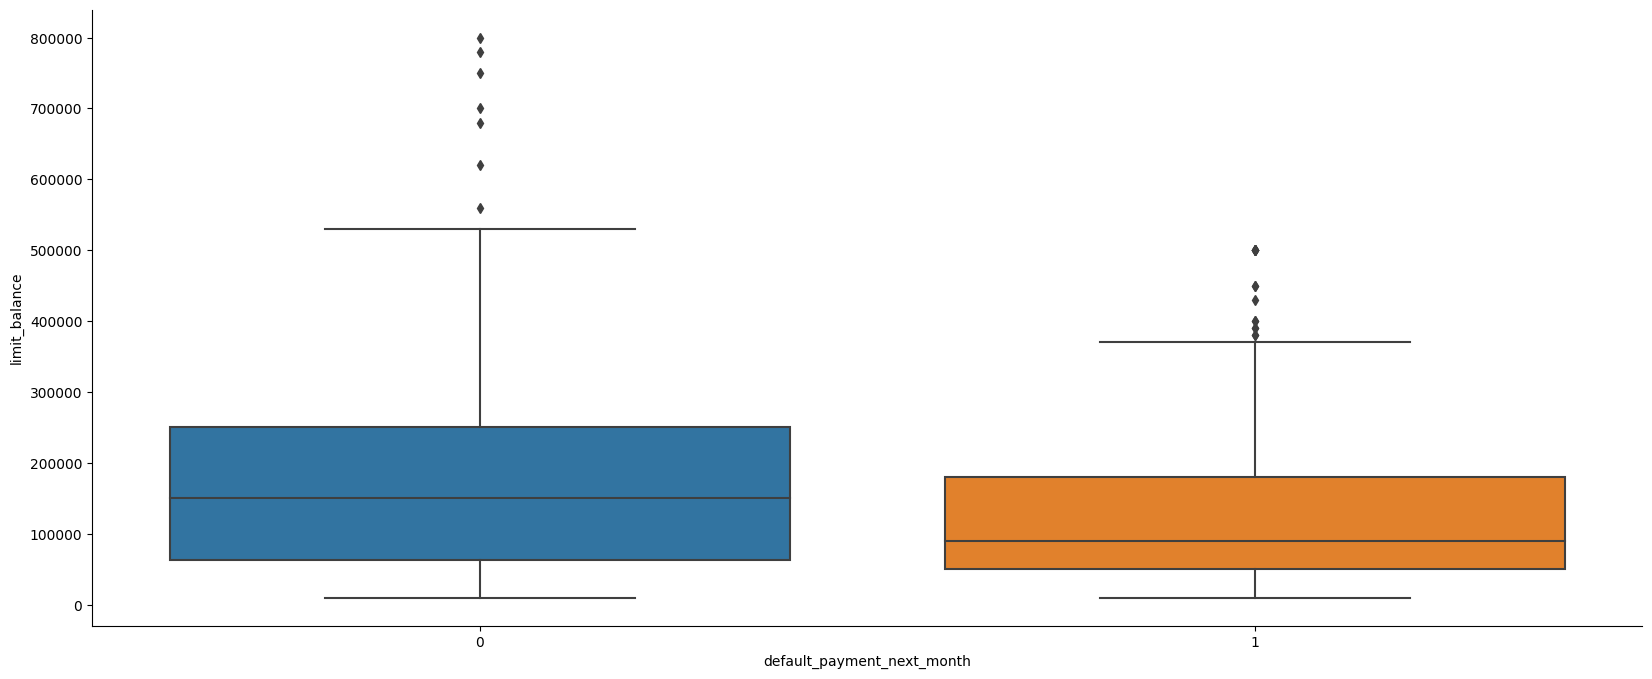

In [16]:
# check limit_balance per label di target
f, ax = plt.subplots(figsize=(20, 8))
sns.despine(f)
sns.boxplot(x='default_payment_next_month', y='limit_balance', data=data_eda);

Banyak dari nasabah yang tidak default memiliki limit_balance yang besar dibandingkan nasabah yang default. Kemungkinan seberapa besar limit_balance yang nasabah miliki berpengaruh terhadap apakah mereka default atau tidak.

### pay_ features and target

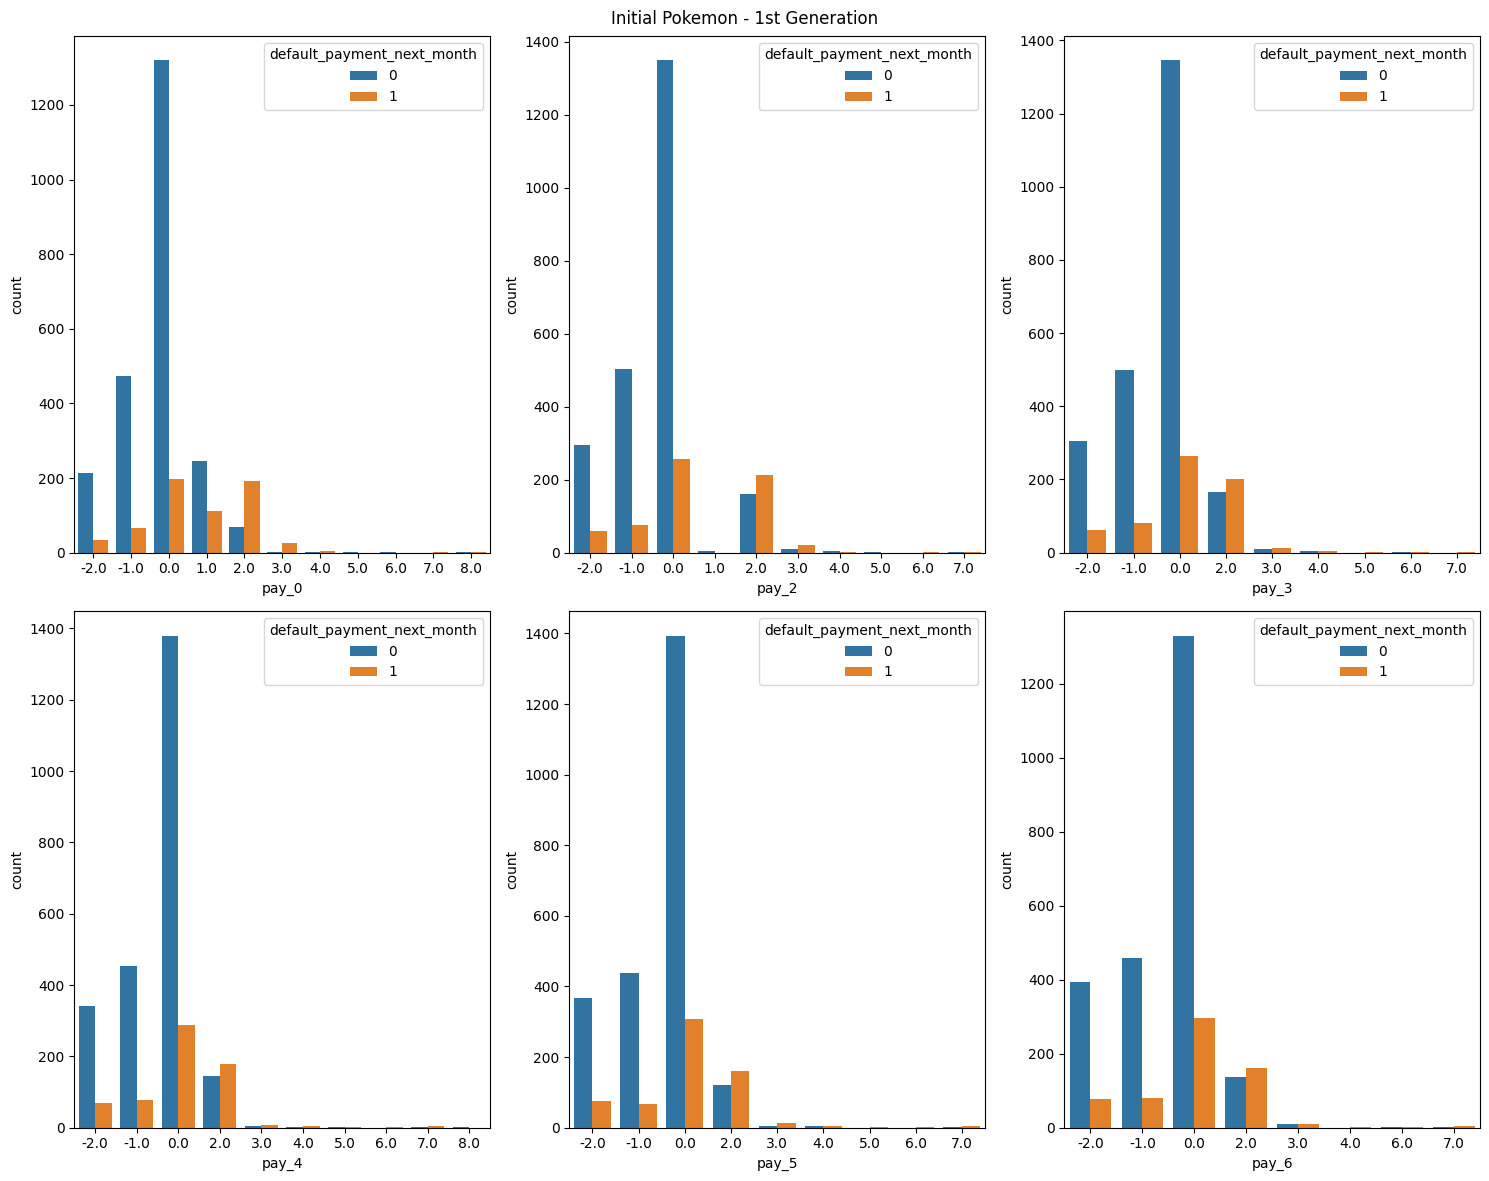

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.countplot(ax=axes[0,0], x=data_eda.pay_0, hue=data_eda.default_payment_next_month)
# axes[0,0].set_title('pay_0')

sns.countplot(ax=axes[0,1], x=data_eda.pay_2, hue=data_eda.default_payment_next_month)
# axes[0,1].set_title('pay_2')

sns.countplot(ax=axes[0,2], x=data_eda.pay_3, hue=data_eda.default_payment_next_month)
# axes[0,2].set_title('pay_3')

sns.countplot(ax=axes[1,0], x=data_eda.pay_4, hue=data_eda.default_payment_next_month)
# axes[1,0].set_title('pay_4')

sns.countplot(ax=axes[1,1], x=data_eda.pay_5, hue=data_eda.default_payment_next_month)
# axes[1,1].set_title('pay_5')

sns.countplot(ax=axes[1,2], x=data_eda.pay_6, hue=data_eda.default_payment_next_month)
# axes[1,2].set_title('pay_6')

fig.tight_layout()

Dengan lebih lamanya keterlambatan nasabah dalam membayar, nasabah memiliki kemungkinan default yang lebih tinggi. Hal tersebut ditunjukkan oleh bar chart di atas, keterlambatan membayar dari 2 bulan ke atas, jumlah nasabah yang default lebih banyak dibandingkan dengan yang tidak. Fenomena ini membuktikan bahwa features categorical pay_0, 2 sampai 6 dapat membedakan apakah nasabah default atau tidak.

### bill_amt_ features and target

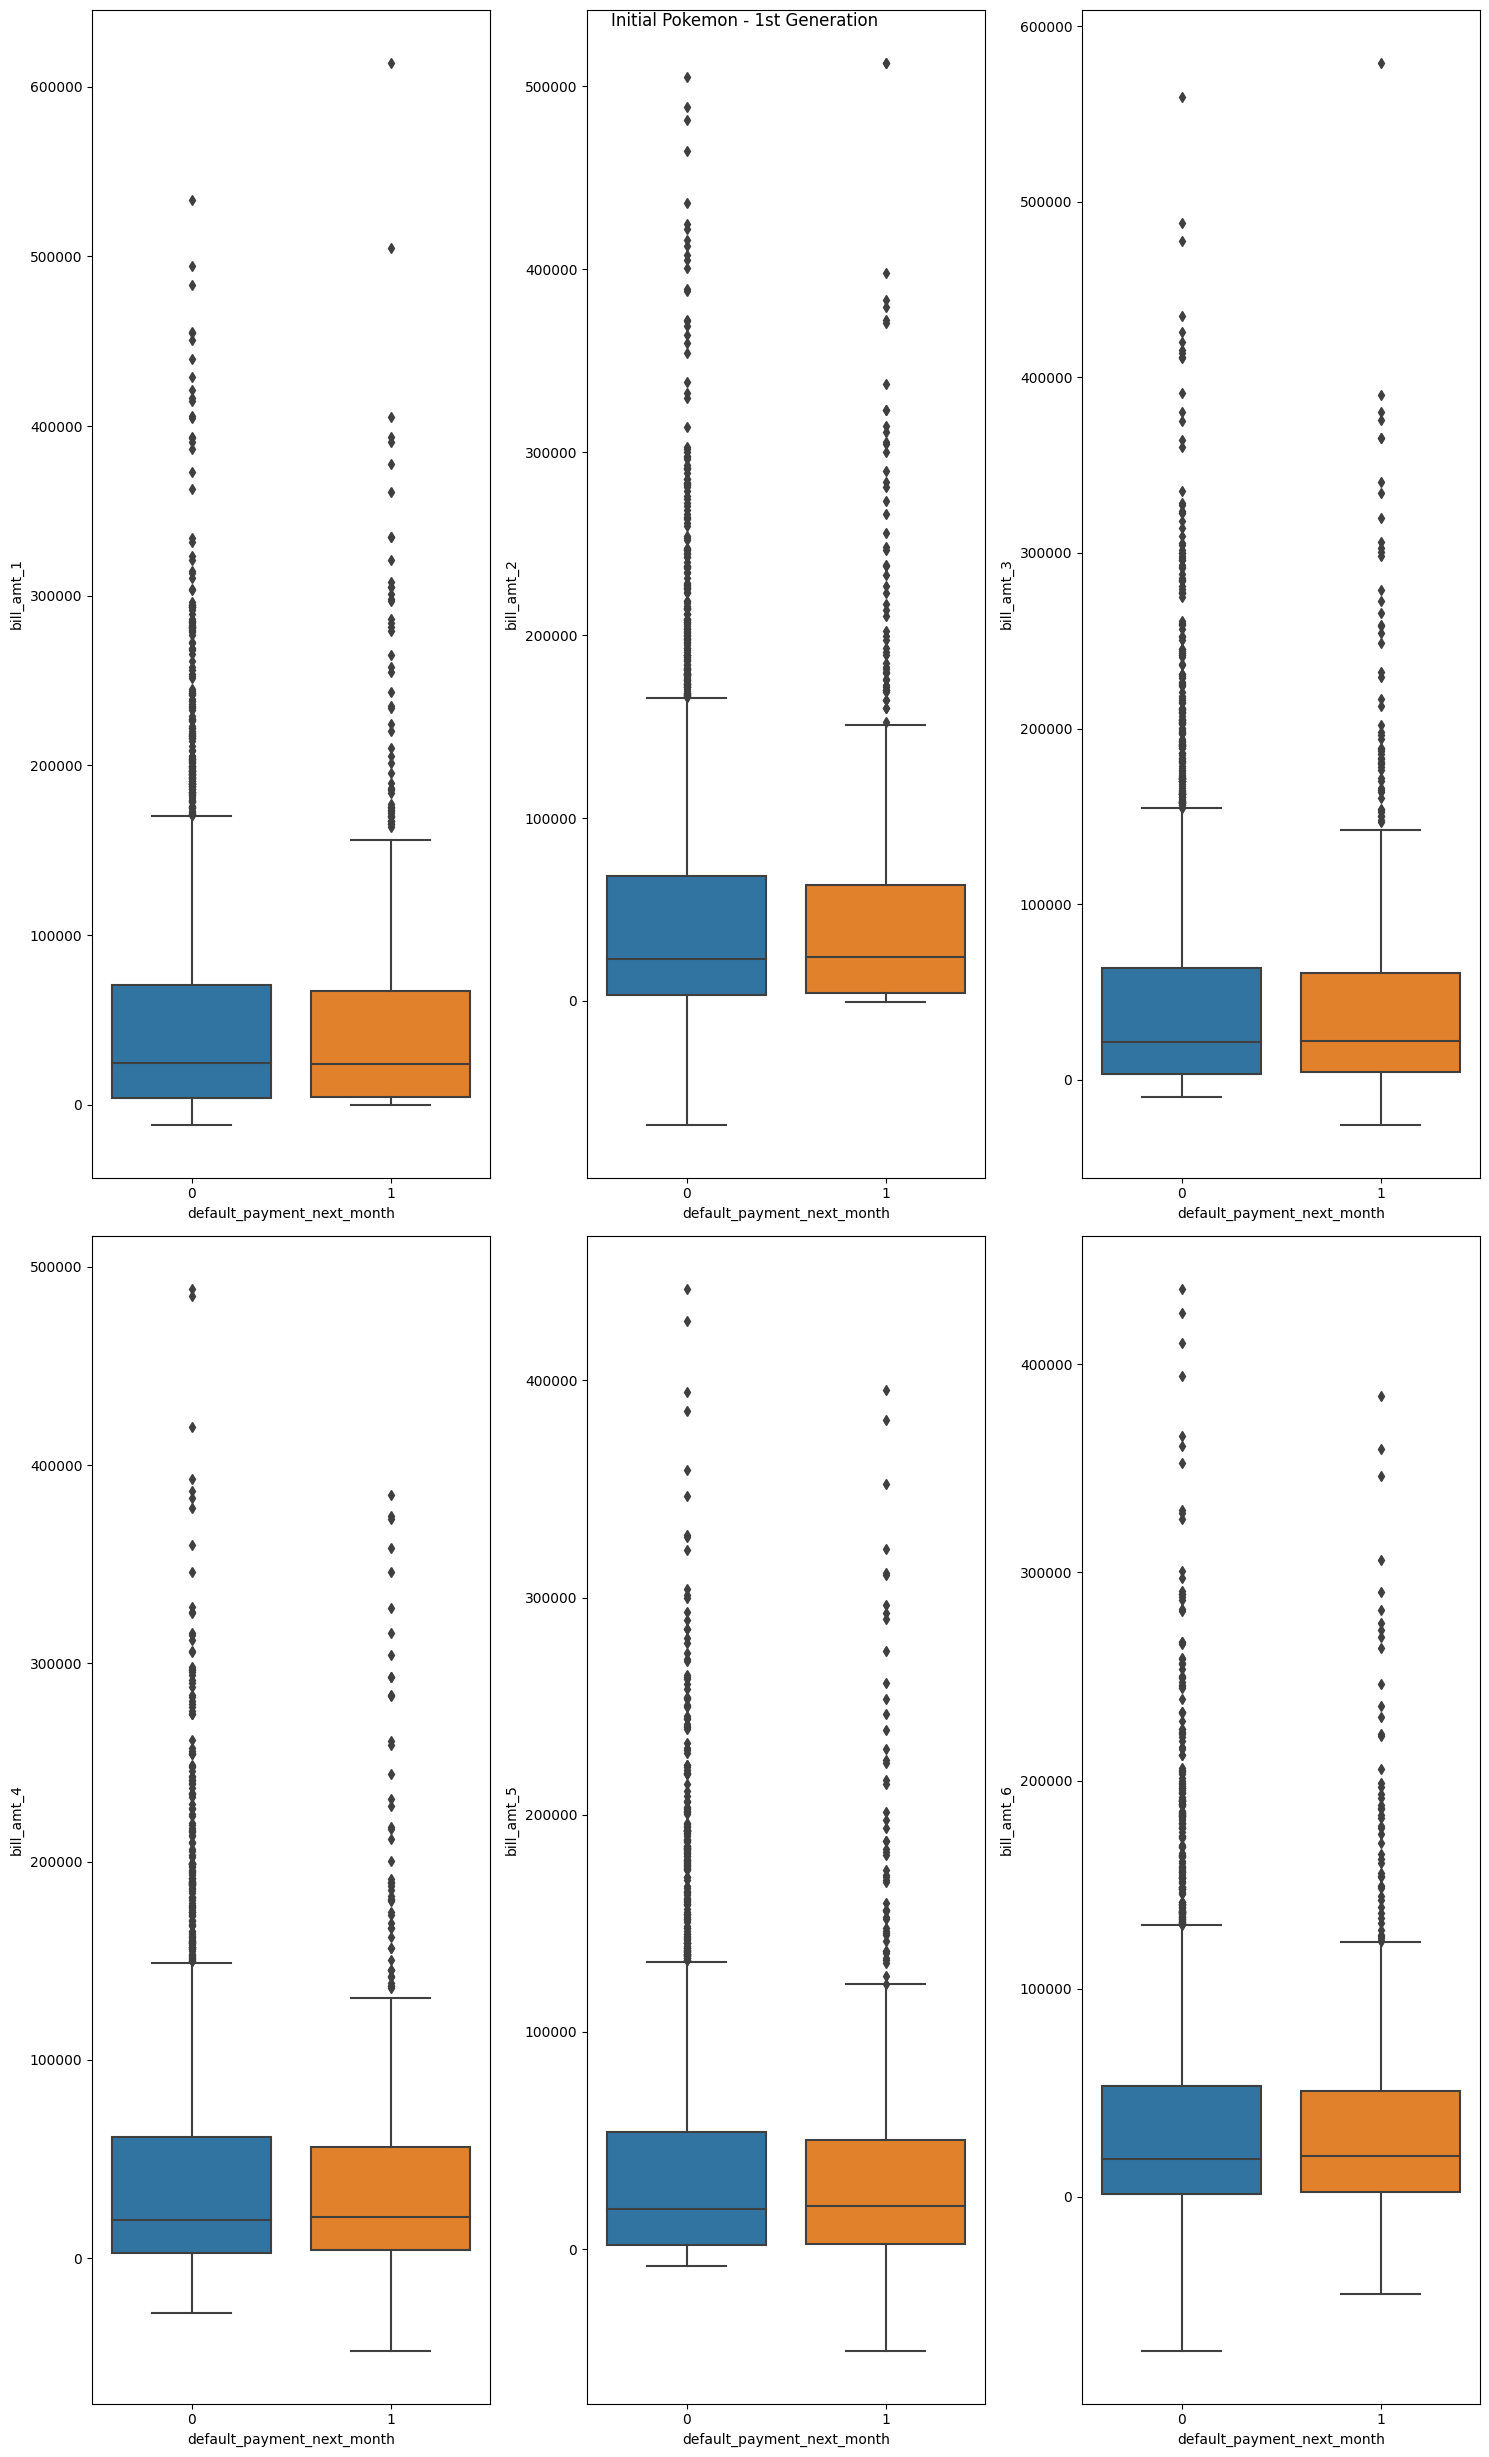

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 25))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.boxplot(ax=axes[0,0], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_1)
# axes[0].set_title('bill_amt_1')

sns.boxplot(ax=axes[0,1], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_2)
# axes[1].set_title('bill_amt_2')

sns.boxplot(ax=axes[0,2], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_3)
# axes[2].set_title('bill_amt_3')

sns.boxplot(ax=axes[1,0], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_4)
# axes[3].set_title('bill_amt_4')

sns.boxplot(ax=axes[1,1], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_5)
# axes[4].set_title('bill_amt_5')

sns.boxplot(ax=axes[1,2], x=data_eda.default_payment_next_month, y=data_eda.bill_amt_6)
# axes[5].set_title('bill_amt_6')

fig.tight_layout()

Bill amount yang dimiliki oleh nasabah yang default dan tidak kurang lebih sama. Mereka tidak tampak membedakan nasabah yang default atau tidak.

### pay_amt_ features and target

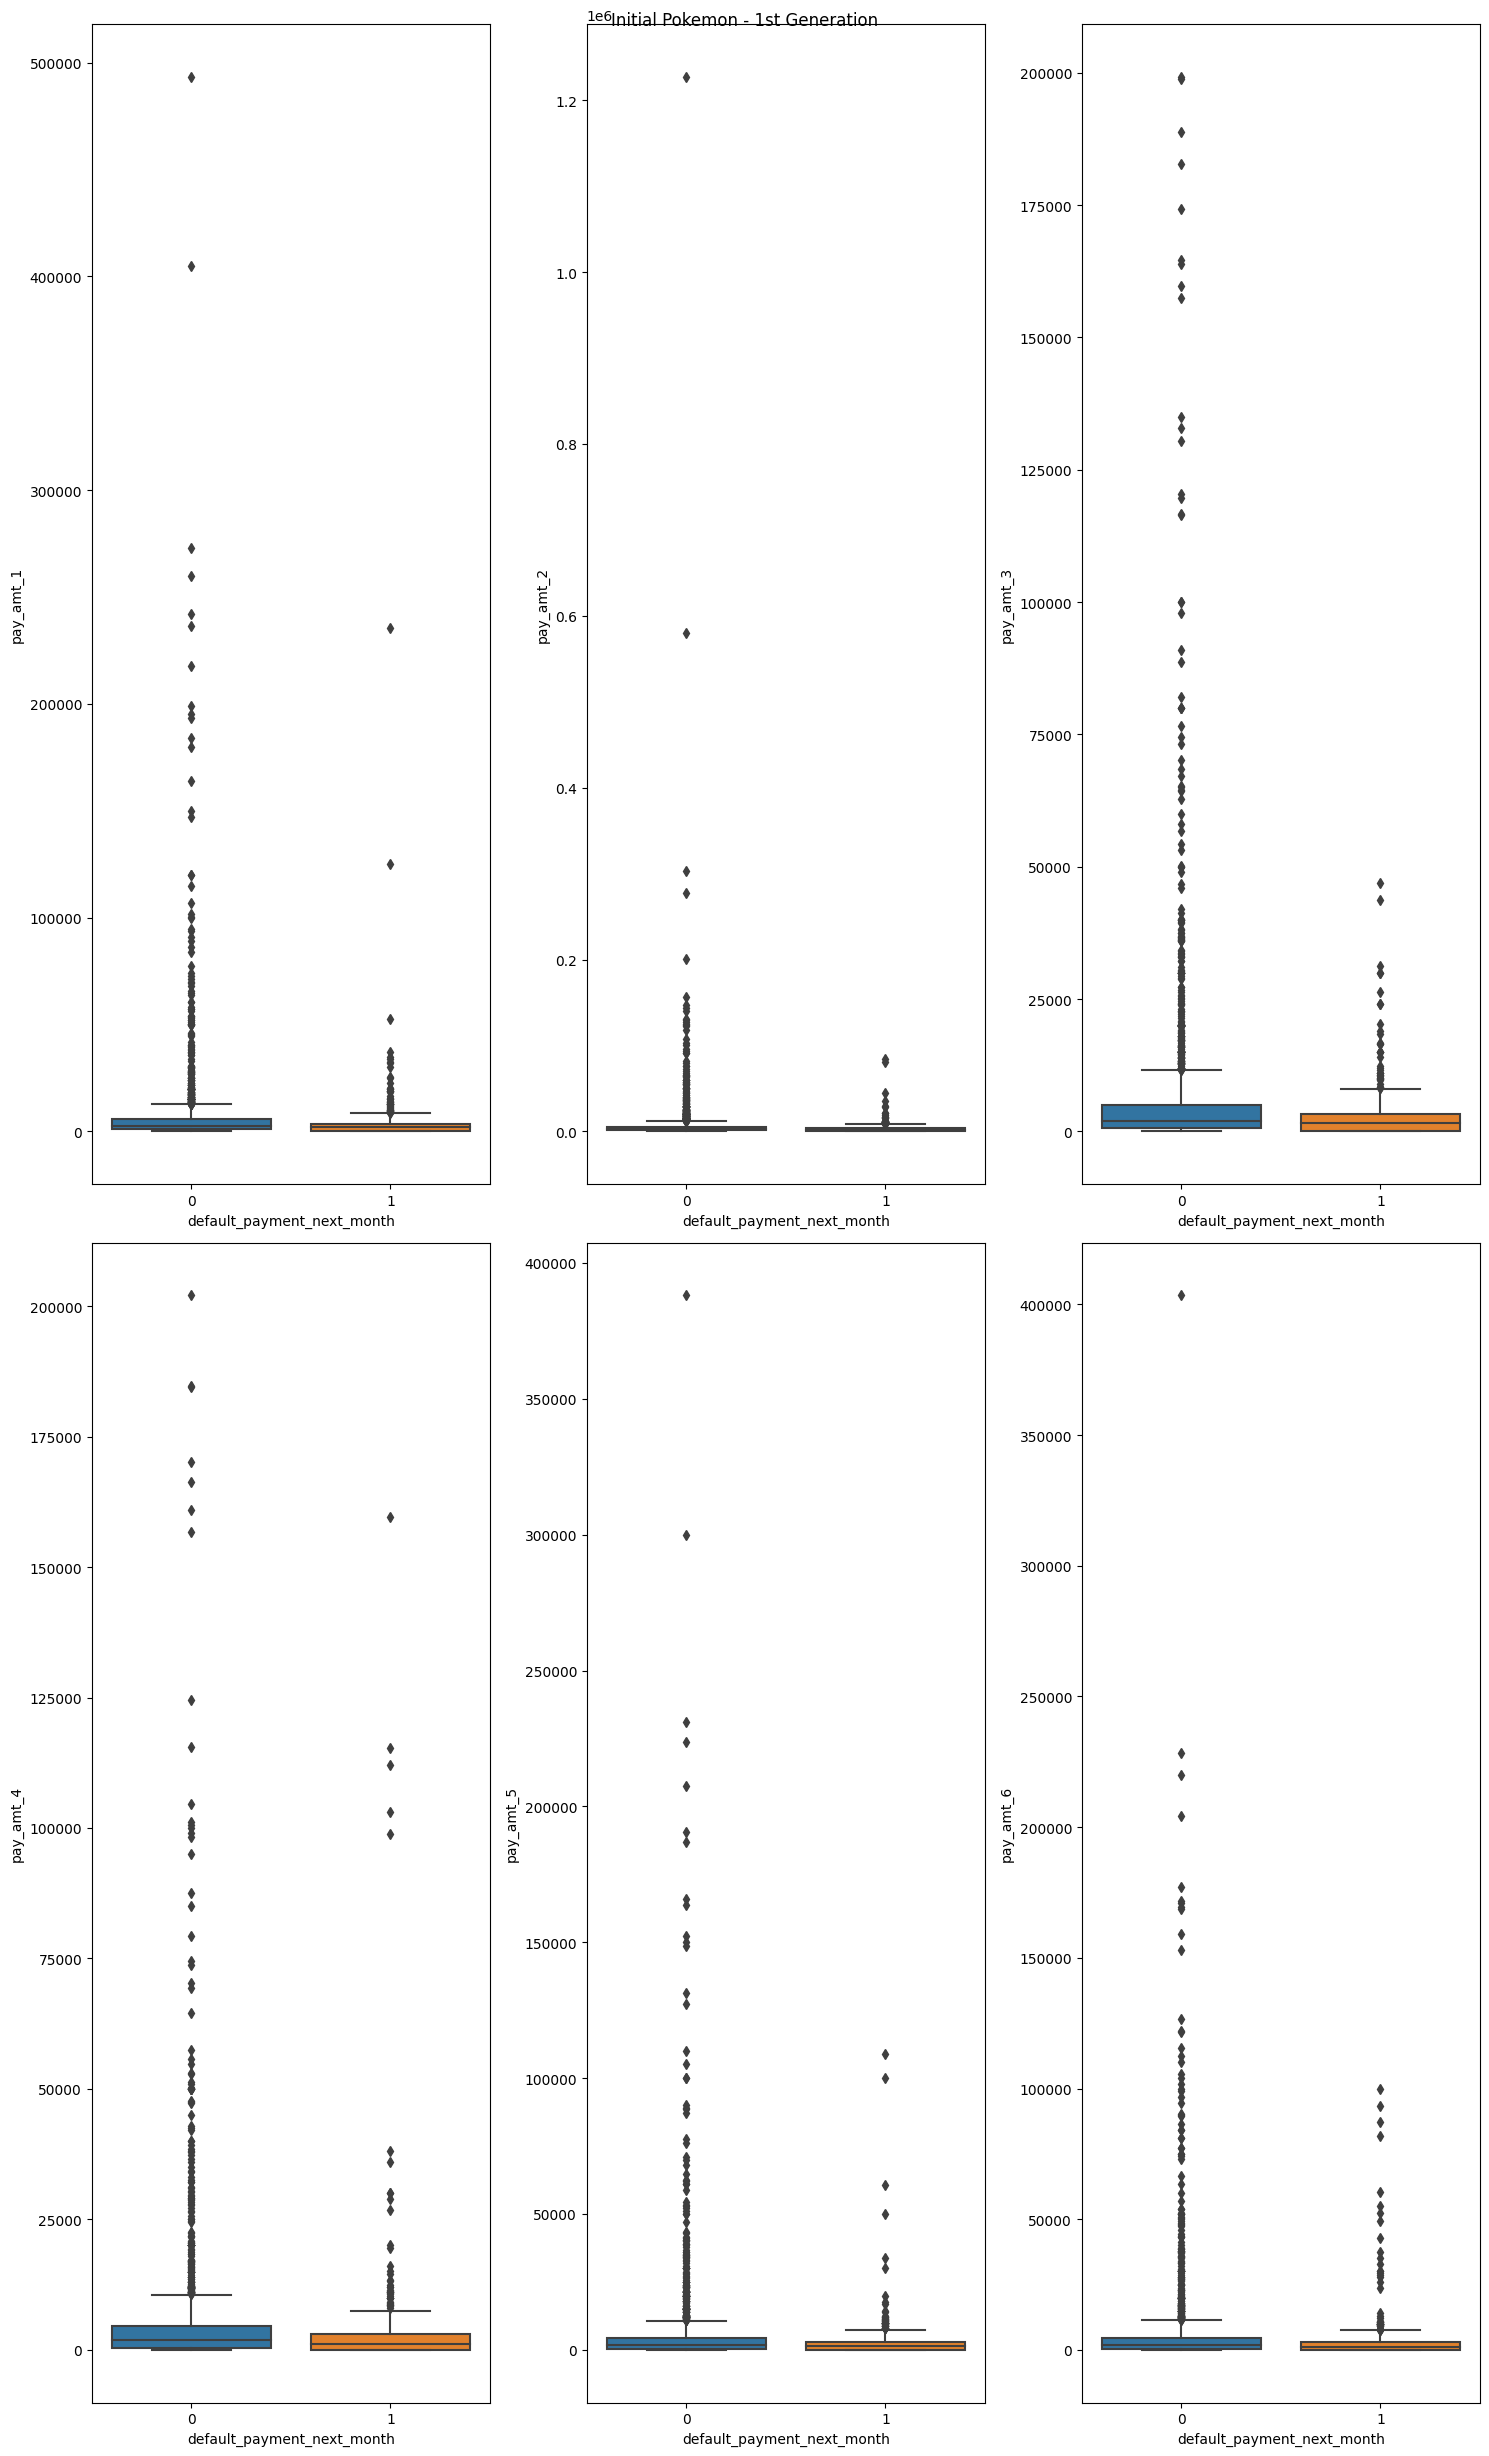

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 25))
fig.suptitle('Initial Pokemon - 1st Generation')

sns.boxplot(ax=axes[0,0], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_1)
# axes[0].set_title('pay_amt_1')

sns.boxplot(ax=axes[0,1], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_2)
# axes[1].set_title('pay_amt_2')

sns.boxplot(ax=axes[0,2], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_3)
# axes[2].set_title('pay_amt_3')

sns.boxplot(ax=axes[1,0], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_4)
# axes[3].set_title('pay_amt_4')

sns.boxplot(ax=axes[1,1], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_5)
# axes[4].set_title('pay_amt_5')

sns.boxplot(ax=axes[1,2], x=data_eda.default_payment_next_month, y=data_eda.pay_amt_6)
# axes[5].set_title('pay_amt_6')

fig.tight_layout()

features pay_amt_ dari 1 sampai 6 memiliki nilai-nilai yang terletak dekat dengan center value yang menyebabkan boxes dari boxplot berbentuk tipis.
Kita bisa melihat bahwa nasabah yang default dan tidak kurang lebih kebanyakan dari mereka memiliki jumlah repayment yang sama. Namun kita juga melihat bahwa, banyak nasabah tidak default banyak yang melakukan repayment dengan nilai sangat tinggi, sedangkan nasabah yang default jarang melakukan repayment yang tinggi, entah itu karena repayment mereka tidak ada yang sangat tinggi atau mereka tidak melakukannya.  
Features pay_amt_ dari 1 sampai 6 terlihat tidak dapat membedakan apakah nasabah default atau tidak.

>---

# Feature Engineering

In [20]:
# copy raw data for feature engineering and machine learning modeling purpose
data = data_raw.copy()

##  Duplicates and Cardinality

### Duplicates

In [21]:
# findout whether there are duplicated rows
data[data.duplicated()]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2381,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Kita menemukan 1 row duplicated, yang mana selanjutnya akan kita hapus.

In [22]:
# jumlah sebelum duplicated dihapus
len(data)

2965

In [23]:
# drop rows yang dupliacted
data.drop_duplicates(inplace=True)

In [24]:
# jumlah setelah duplicated dihapus
len(data)

2964

### Cardinality

Karena marital status sudah diencode, kita tidak bisa melakukan handling cardinality terhadap feature tersebut.

## Spit to X and y

In [25]:
# memisahkan data ke X dan y data
X = data.drop('default_payment_next_month', axis=1)
y = data['default_payment_next_month']

## Train Test Split

In [26]:
# Memisahkan X dan y ke train dan test
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [27]:
# Melihat jumlah Train set dan Test set
print(f'{"Train Set" }   {"Test Set"}')
print(f'{X_train.shape} {X_test.shape}')
print(f'{y_train.shape}   {y_test.shape}')

Train Set   Test Set
(2371, 23) (593, 23)
(2371,)   (593,)


In [28]:
# Melihat distribusi target di Training Set
y_train.value_counts() / len(y_train)

0    0.785744
1    0.214256
Name: default_payment_next_month, dtype: float64

In [29]:
# Melihat distribusi target di Testing Set
y_test.value_counts() / len(y_test)

0    0.785835
1    0.214165
Name: default_payment_next_month, dtype: float64

Training Set dan Testing Set memiliki porsi percentage yang sama.

## X_train

### Handling Outliers

#### limit_balance

In [30]:
# Melihat min, max, mean dari kolom limit_balance
kolom = 'limit_balance'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

limit_balance min : 10000.00
limit_balance max : 800000.00
limit_balance mean: 163724.17


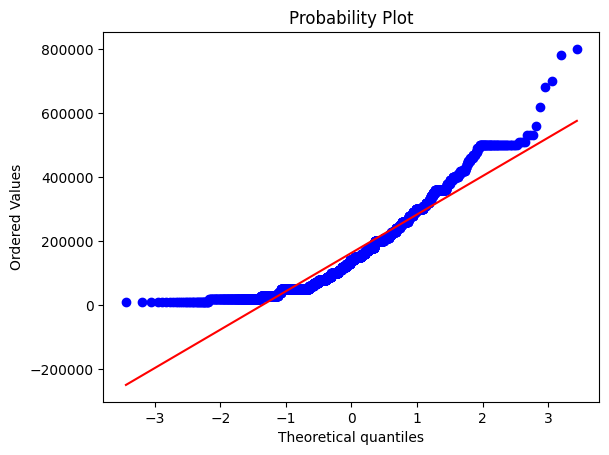

In [31]:
st.probplot(X_train.limit_balance, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature limit_balance tidak berdistribusi normal.

In [32]:
t_test , p_value = st.kstest(X_train.limit_balance, 'norm')
print('stat=%.3f, p_value=%3f\n' % (t_test, p_value))
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=1.000, p_value=0.000000

Probably not Gaussian


Berdasarkan Kolmogorov-Smirnov test feature limit_balance tidak berdistribusi normal

In [33]:
# Melihat lower, upper limit dari limit_balance dan outliersnya
data_series = X_train.limit_balance
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [34]:
lower

-220000.0

In [35]:
data_series[outliers_below_lower]

Series([], Name: limit_balance, dtype: float64)

limit_balance tidak memiliki outliers di luar batas bawah.

In [36]:
upper

500000.0

In [37]:
data_series[outliers_over_upper]

2591    800000.0
923     680000.0
14      780000.0
606     530000.0
1780    530000.0
2846    620000.0
1121    510000.0
734     560000.0
1794    530000.0
2541    510000.0
523     700000.0
933     510000.0
446     510000.0
Name: limit_balance, dtype: float64

Kita melihat bahwa data limit balance tidak terlalu berbeda secara significan dengan upper boundary, yang mana menunjukkan kita tidak perlu menghapus outliers tersebut. Outliers tersebut juga masuk akal untuk orang-orang yang sangat kaya.

#### age

In [38]:
# Melihat min, max, mean dari kolom age
kolom = 'age'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

age min : 21.00
age max : 69.00
age mean: 35.22


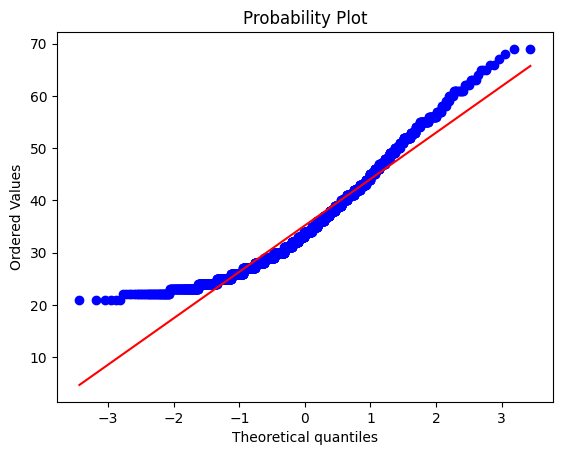

In [39]:
st.probplot(X_train.age, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature age tidak berdistribusi normal.

In [40]:
t_test , p_value = st.kstest(X_train.age, 'norm')
print('stat=%.3f, p_value=%3f\n' % (t_test, p_value))
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=1.000, p_value=0.000000

Probably not Gaussian


In [41]:
# Melihat lower, upper limit dari age dan outliersnya
data_series = X_train.age
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [42]:
lower

8.5

In [43]:
data_series[outliers_below_lower]

Series([], Name: age, dtype: float64)

age tidak memiliki outliers di luar batas bawah.

In [44]:
upper

60.5

In [45]:
data_series[outliers_over_upper]

405     63.0
2359    65.0
1575    65.0
47      61.0
207     61.0
82      65.0
530     64.0
1169    62.0
2653    61.0
847     69.0
1758    61.0
1424    62.0
2063    62.0
1121    61.0
2048    61.0
31      61.0
1191    63.0
463     63.0
2342    67.0
1874    63.0
19      66.0
1589    61.0
2026    61.0
472     69.0
1987    66.0
1813    68.0
133     62.0
446     61.0
Name: age, dtype: float64

Outliers pada umur juga tidak berbeda significant dengan upper boundary. Maka dari itu tidak akan kita hapus.

#### bill_amt_1

In [46]:
# Melihat min, max, mean dari kolom bill_amt_1
kolom = 'bill_amt_1'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_1 min : -11545.00
bill_amt_1 max : 613860.00
bill_amt_1 mean: 51788.52


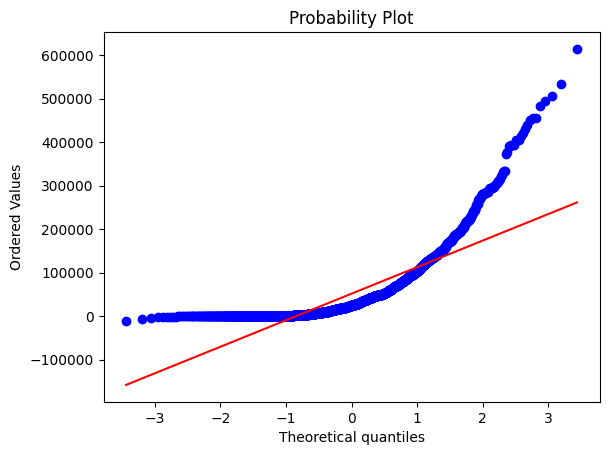

In [47]:
st.probplot(X_train.bill_amt_1, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_1 tidak berdistribusi normal.

In [48]:
# Melihat lower, upper limit dari bill_amt_1 dan outliersnya
data_series = X_train.bill_amt_1
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [49]:
lower

-94391.25

In [50]:
data_series[outliers_below_lower]

Series([], Name: bill_amt_1, dtype: float64)

bill_amt_1 tidak memiliki outliers di luar batas bawah.

In [51]:
upper

167502.75

In [52]:
(data_series[outliers_over_upper] / upper).mean()

1.5179668955391161

In [53]:
data_series[outliers_over_upper].max() / upper

3.6647756529370414

Menurut penulis 3.7 kali lipat dari upper boundary adalah angka yang besar, namun untuk sekarang kita tidak akan menghapus angka tersebut sebelum melihat hasil modelnya. Angkat tersebut besar namun tidak terlalu besar yang bisa dibilang nggak masuk akal.

#### bill_amt_2

In [54]:
# Melihat min, max, mean dari kolom bill_amt_2
kolom = 'bill_amt_2'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_2 min : -9850.00
bill_amt_2 max : 512650.00
bill_amt_2 mean: 50506.71


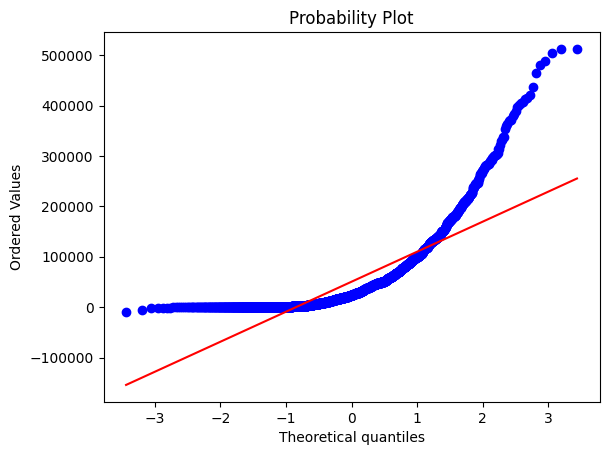

In [55]:
st.probplot(X_train.bill_amt_2, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_2 tidak berdistribusi normal.

In [56]:
# Melihat lower, upper limit dari bill_amt_2 dan outliersnya
data_series = X_train.bill_amt_2
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [57]:
lower

-92261.5

In [58]:
data_series[outliers_below_lower]

Series([], Name: bill_amt_2, dtype: float64)

bill_amt_2 tidak memiliki outliers di luar batas bawah.

In [59]:
upper

162662.5

In [60]:
(data_series[outliers_over_upper] / upper).mean()

1.5236092610686016

In [61]:
data_series[outliers_over_upper].max() / upper

3.1516176131560747

outliers di bill_amt_2 mimiliki angka-angka yang hampir mirip dengan bill_amt_1, maka dari itu kita juga akan membiarkanya terlebih dahulu.

#### bill_amt_3

In [62]:
# Melihat min, max, mean dari kolom bill_amt_3
kolom = 'bill_amt_3'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_3 min : -25443.00
bill_amt_3 max : 578971.00
bill_amt_3 mean: 48416.75


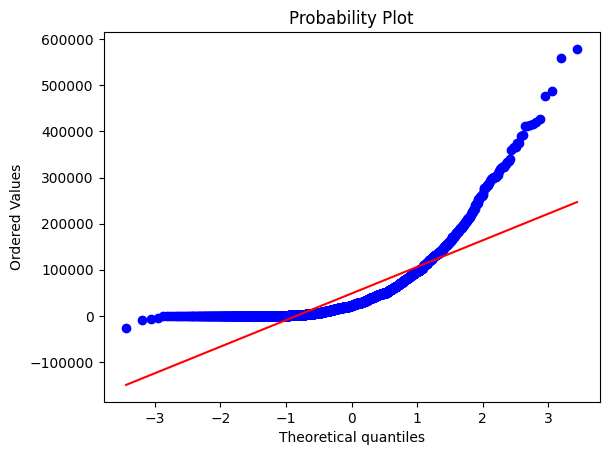

In [63]:
st.probplot(X_train.bill_amt_3, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_3 tidak berdistribusi normal.

In [64]:
# Melihat lower, upper limit dari bill_amt_3 dan outliersnya
data_series = X_train.bill_amt_3
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [65]:
lower

-86509.25

In [66]:
data_series[outliers_below_lower]

Series([], Name: bill_amt_3, dtype: float64)

bill_amt_3 tidak memiliki outliers di luar batas bawah.

In [67]:
upper

152908.75

In [68]:
(data_series[outliers_over_upper] / upper).mean()

1.5612809027341803

In [69]:
data_series[outliers_over_upper].max() / upper

3.7863824012687304

Outliers di bill_amt_3 masih bisa dibilang kecil jika dibandingkan dengan upper limitnya.

#### bill_amt_4

In [70]:
# Melihat min, max, mean dari kolom bill_amt_4
kolom = 'bill_amt_4'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_4 min : -46627.00
bill_amt_4 max : 488808.00
bill_amt_4 mean: 44075.73


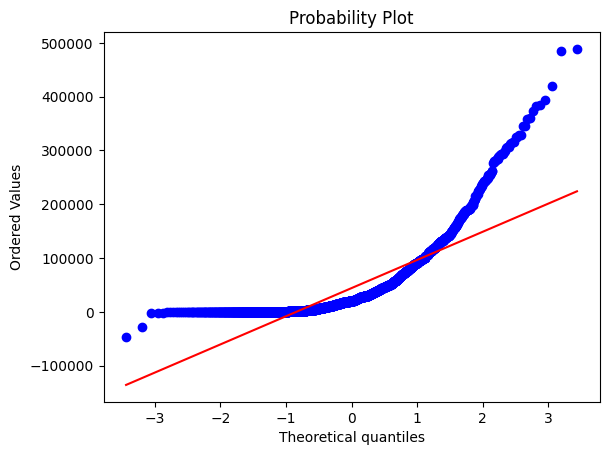

In [71]:
st.probplot(X_train.bill_amt_4, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_4 tidak berdistribusi normal.

In [72]:
# Melihat lower, upper limit dari bill_amt_4 dan outliersnya
data_series = X_train.bill_amt_4
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [73]:
lower

-80797.0

In [74]:
data_series[outliers_below_lower]

Series([], Name: bill_amt_4, dtype: float64)

bill_amt_4 tidak memiliki outliers di luar batas bawah.

In [75]:
upper

141399.0

In [76]:
(data_series[outliers_over_upper] / upper).mean()

1.555251708736528

In [77]:
data_series[outliers_over_upper].max() / upper

3.456940996753867

Outliers di bill_amt_4 masih bisa dibilang kecil jika dibandingkan dengan upper limitnya.

#### bill_amt_5

In [78]:
# Melihat min, max, mean dari kolom bill_amt_5
kolom = 'bill_amt_5'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_5 min : -46627.00
bill_amt_5 max : 441981.00
bill_amt_5 mean: 40989.54


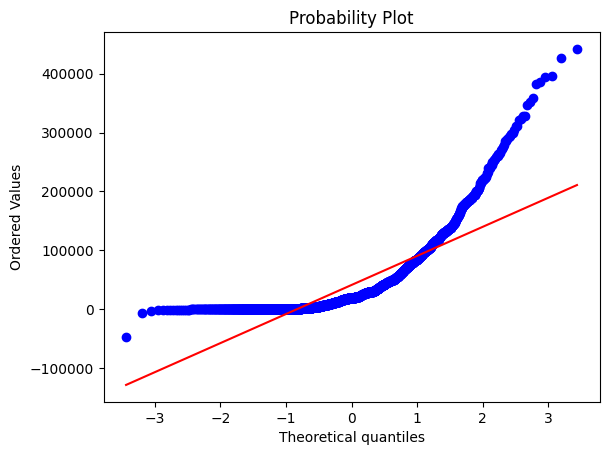

In [79]:
st.probplot(X_train.bill_amt_5, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_5 tidak berdistribusi normal.

In [80]:
# Melihat lower, upper limit dari bill_amt_5 dan outliersnya
data_series = X_train.bill_amt_5
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [81]:
lower

-73713.5

In [82]:
data_series[outliers_below_lower]

Series([], Name: bill_amt_5, dtype: float64)

bill_amt_1 tidak memiliki outliers di luar batas bawah.

In [83]:
upper

128070.5

In [84]:
(data_series[outliers_over_upper] / upper).mean()

1.5267199371774587

In [85]:
data_series[outliers_over_upper].max() / upper

3.451075774670982

Outliers di bill_amt_5 masih bisa dibilang kecil jika dibandingkan dengan upper limitnya.

#### bill_amt_6

In [86]:
# Melihat min, max, mean dari kolom bill_amt_6
kolom = 'bill_amt_6'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

bill_amt_6 min : -73895.00
bill_amt_6 max : 436172.00
bill_amt_6 mean: 39472.85


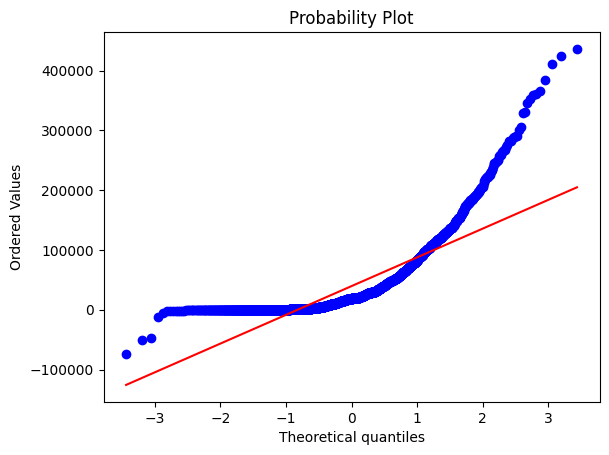

In [87]:
st.probplot(X_train.bill_amt_6, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature bill_amt_6 tidak berdistribusi normal.

In [88]:
# Melihat lower, upper limit dari bill_amt_6 dan outliersnya
data_series = X_train.bill_amt_6
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [89]:
lower

-73578.75

In [90]:
data_series[outliers_below_lower]

818   -73895.0
Name: bill_amt_6, dtype: float64

bill_amt_6 memiliki 1 outlier yang tidak berbeda jauh dengan batas bawah

In [91]:
upper

126315.25

In [92]:
(data_series[outliers_over_upper] / upper).mean()

1.5234227405188554

In [93]:
data_series[outliers_over_upper].max() / upper

3.453043080704824

Outliers di bill_amt_3 masih bisa dibilang kecil jika dibandingkan dengan upper limitnya.

Outliers di bill_amt_1, 2, sampai 6 tidak bisa dibilang terlalu besar yang mana harus kita hapus atau transformasi.

#### pay_amt_1

In [94]:
# Melihat min, max, mean dari kolom pay_amt_1
kolom = 'pay_amt_1'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_1 min : 0.00
pay_amt_1 max : 493358.00
pay_amt_1 mean: 6318.41


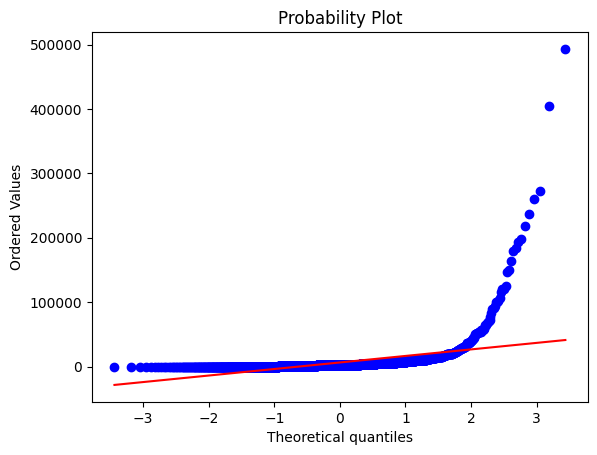

In [95]:
st.probplot(X_train.pay_amt_1, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_1 tidak berdistribusi normal.

In [96]:
# Melihat lower, upper limit dari pay_amt_1 dan outliersnya
data_series = X_train.pay_amt_1
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [97]:
lower

-5003.75

In [98]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_1, dtype: float64)

pay_amt_1 tidak memiliki outliers di luar batas bawah.

In [99]:
upper

11006.25

In [100]:
(data_series[outliers_over_upper] / upper).mean()

3.7476950080016525

In [101]:
data_series[outliers_over_upper].max() / upper

44.82525837592277

In [102]:
data_series[outliers_over_upper]

2475     27657.0
569      50070.0
2115     14165.0
217      18280.0
2522    100496.0
          ...   
2576     40146.0
127      29456.0
245      25001.0
659      13521.0
2701     11515.0
Name: pay_amt_1, Length: 220, dtype: float64

Outliers di pay_amt_1 memiliki banyak angka yang sangat besar dibanding dengan upper limitnya. Maka dari itu kita akan melakukan tranformasi menggunakan Winsorization.

#### pay_amt_2

In [103]:
# Melihat min, max, mean dari kolom pay_amt_2
kolom = 'pay_amt_2'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_2 min : 0.00
pay_amt_2 max : 1227082.00
pay_amt_2 mean: 6344.79


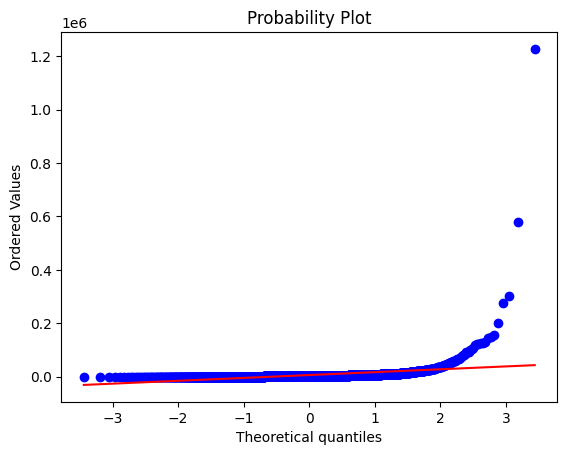

In [104]:
st.probplot(X_train.pay_amt_2, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_2 tidak berdistribusi normal.

In [105]:
# Melihat lower, upper limit dari pay_amt_2 dan outliersnya
data_series = X_train.pay_amt_2
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [106]:
lower

-5141.25

In [107]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_2, dtype: float64)

pay_amt_2 tidak memiliki outliers di luar batas bawah.

In [108]:
upper

11084.75

In [109]:
(data_series[outliers_over_upper] / upper).mean()

3.907044719410756

In [110]:
data_series[outliers_over_upper].max() / upper

110.70001578745574

In [111]:
data_series[outliers_over_upper][(data_series[outliers_over_upper] / upper) > 5]

2115      55732.0
1789      69900.0
1061      63000.0
2591      64657.0
2816     302961.0
2655     123000.0
1817      59483.0
1781     117698.0
2440     143200.0
1934     200304.0
896       76000.0
2087     126768.0
2897      91269.0
222       93575.0
2605      66066.0
2454      65748.0
2490      60000.0
899      107139.0
2534      72356.0
1445     130000.0
1165     146896.0
2805      82271.0
1784     580464.0
1842     100483.0
2669     103142.0
2086      81256.0
1791     277510.0
1787     156292.0
2541    1227082.0
2603      91272.0
328      124500.0
244       60259.0
1779     123514.0
2652      84440.0
1358      57428.0
Name: pay_amt_2, dtype: float64

pay_amt_2 memiliki outliers yang sangat berbeda dengan upper limitnya. maka dari itu kita juga akan melakukan transformasi dengan Winsorization.

#### pay_amt_3

In [112]:
# Melihat min, max, mean dari kolom pay_amt_3
kolom = 'pay_amt_3'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_3 min : 0.00
pay_amt_3 max : 199209.00
pay_amt_3 mean: 5149.41


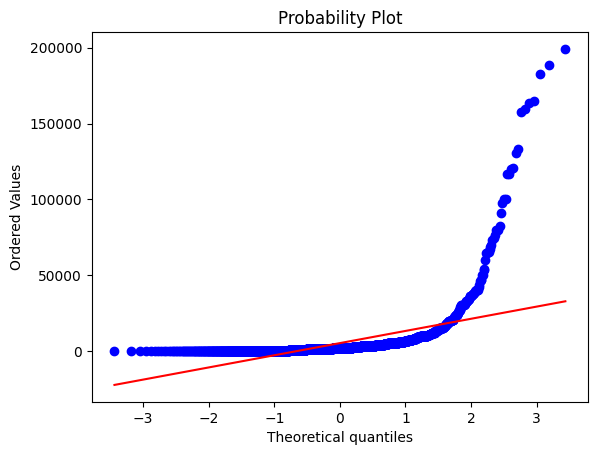

In [113]:
st.probplot(X_train.pay_amt_3, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_3 tidak berdistribusi normal.

In [114]:
# Melihat lower, upper limit dari pay_amt_3 dan outliersnya
data_series = X_train.pay_amt_3
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [115]:
lower

-5216.25

In [116]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_3, dtype: float64)

pay_amt_3 tidak memiliki outliers di luar batas bawah.

In [117]:
upper

9969.75

In [118]:
(data_series[outliers_over_upper] / upper).mean()

3.026797468592492

In [119]:
data_series[outliers_over_upper].max() / upper

19.981343564281953

In [120]:
data_series[outliers_over_upper][(data_series[outliers_over_upper] / upper) > 5]

1174    120444.0
1950    132872.0
2517     64395.0
2733     90872.0
1381    116380.0
1541     80000.0
2466    100000.0
2543     65243.0
2715     76552.0
762      50054.0
407      80000.0
1876     82150.0
2530     54271.0
2534    199209.0
1165    157436.0
977      64442.0
2544     73158.0
1784     80017.0
1842    116567.0
2531     97874.0
2533    159738.0
2669     68541.0
549     182781.0
188      70092.0
2541    164577.0
1186    163862.0
2312    130447.0
2612     50000.0
2621    119685.0
918     100000.0
1009     65000.0
2546    188841.0
1898     67211.0
2562     53198.0
603      60000.0
1185     74550.0
Name: pay_amt_3, dtype: float64

pay_amt_3 tidak memiliki outliers tidak memiliki perbedaan yang sangat jauh dari upper limit seperti features pay_amt_1 dan 2. Namun feature ini tetap akan kita lakukan transformasi dengan Winsorization.

#### pay_amt_4

In [121]:
# Melihat min, max, mean dari kolom pay_amt_4
kolom = 'pay_amt_4'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_4 min : 0.00
pay_amt_4 max : 184637.00
pay_amt_4 mean: 4429.54


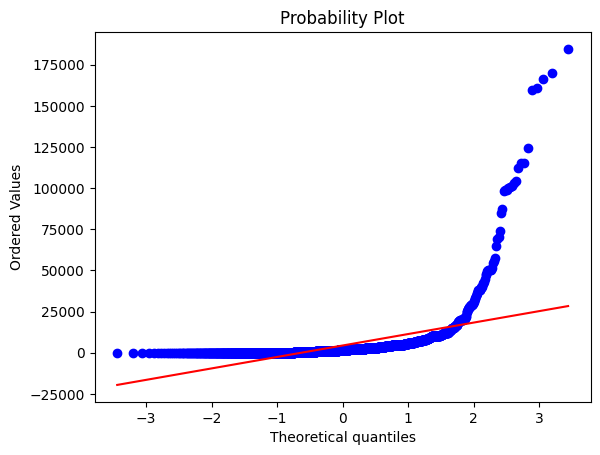

In [122]:
st.probplot(X_train.pay_amt_4, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_4 tidak berdistribusi normal.

In [123]:
# Melihat lower, upper limit dari pay_amt_4 dan outliersnya
data_series = X_train.pay_amt_4
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [124]:
lower

-5208.75

In [125]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_4, dtype: float64)

pay_amt_4 tidak memiliki outliers di luar batas bawah.

In [126]:
upper

9525.25

In [127]:
(data_series[outliers_over_upper] / upper).mean()

3.102422258633382

In [128]:
data_series[outliers_over_upper].max() / upper

19.383953177081967

In [129]:
data_series[outliers_over_upper][(data_series[outliers_over_upper] / upper) > 5]

2579     50000.0
2816    104673.0
1894     55762.0
2793     87476.0
1585    159658.0
1134     49920.0
1770     98828.0
251     115440.0
1796     85096.0
124      47700.0
1805     73758.0
2466     50000.0
759      98231.0
2715    100566.0
2803     64617.0
2542     70331.0
758      69245.0
2278    115399.0
1794    166210.0
430      50000.0
181     170039.0
1842     50156.0
549      99000.0
675     124479.0
1912    101170.0
232     112000.0
521     100000.0
556      51301.0
1797    184637.0
1628    103000.0
1293     57500.0
1175    160897.0
446      50000.0
2701     54807.0
Name: pay_amt_4, dtype: float64

pay_amt_4 memiliki outliers yang hampir sama besarnya seperti pay_amt_3. Maka dari itu kita akan melakukan transformasi dengan Winsorization.

#### pay_amt_5

In [130]:
# Melihat min, max, mean dari kolom pay_amt_5
kolom = 'pay_amt_5'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_5 min : 0.00
pay_amt_5 max : 231133.00
pay_amt_5 mean: 4568.50


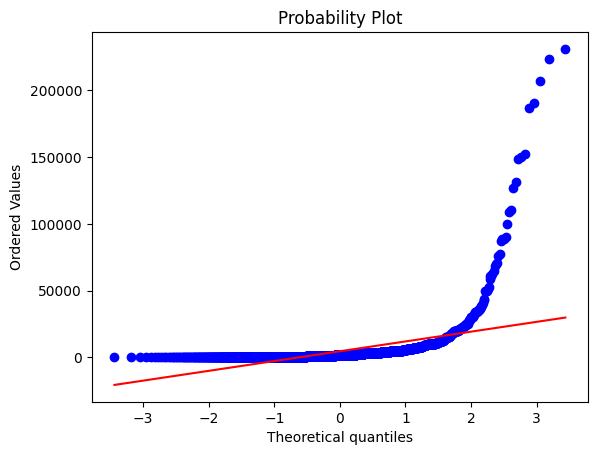

In [131]:
st.probplot(X_train.pay_amt_5, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_5 tidak berdistribusi normal.

In [132]:
# Melihat lower, upper limit dari pay_amt_5 dan outliersnya
data_series = X_train.pay_amt_5
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [133]:
lower

-5208.75

In [134]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_5, dtype: float64)

pay_amt_5 tidak memiliki outliers di luar batas bawah.

In [135]:
upper

9525.25

In [136]:
(data_series[outliers_over_upper] / upper).mean()

3.1571745321465325

In [137]:
data_series[outliers_over_upper].max() / upper

24.265294874150285

In [138]:
data_series[outliers_over_upper][(data_series[outliers_over_upper] / upper) > 5]

1337     70027.0
1061     52343.0
2316     88632.0
1302    131438.0
218     223765.0
1323     58895.0
1361    127187.0
1299    190710.0
1747     77500.0
2001    231133.0
1298    148482.0
3       207440.0
1409     89035.0
7        50000.0
1121     50000.0
1422     51269.0
1372     87045.0
2515    110142.0
2639    152446.0
2531    100000.0
2669     76056.0
2707     68095.0
1114     50000.0
1326     64895.0
1319    109000.0
244      90114.0
1311     61067.0
1815    186732.0
1813     71062.0
2626     61084.0
754     150000.0
2701     62534.0
Name: pay_amt_5, dtype: float64

pay_amt_5 juga memiliki outliers yang besarnya tidak terlalu berbeda dengan pay_amt_3. Maka dari itu kita akan melakukan transformasi dengan Winsorization.

#### pay_amt_6

In [139]:
# Melihat min, max, mean dari kolom pay_amt_6
kolom = 'pay_amt_6'
print(f'{kolom} min : {np.min(X_train[kolom]):.2f}')
print(f'{kolom} max : {np.max(X_train[kolom]):.2f}')
print(f'{kolom} mean: {np.mean(X_train[kolom]):.2f}')

pay_amt_6 min : 0.00
pay_amt_6 max : 403500.00
pay_amt_6 mean: 5381.84


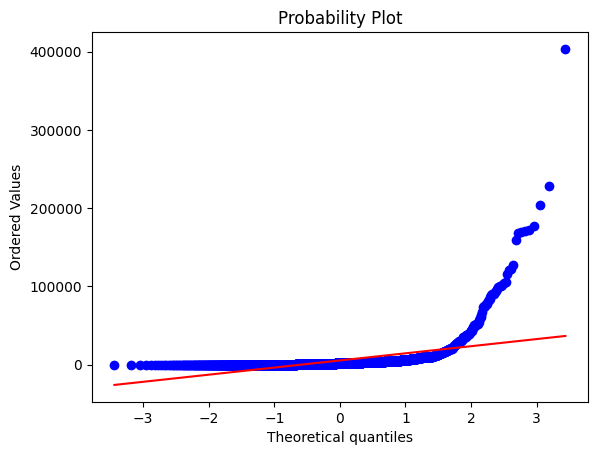

In [140]:
st.probplot(X_train.pay_amt_6, dist="norm", plot=pylab)
pylab.show()

Berdasarkan Q-Q plot feature pay_amt_6 tidak berdistribusi normal.

In [141]:
# Melihat lower, upper limit dari pay_amt_6 dan outliersnya
data_series = X_train.pay_amt_6
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index

In [142]:
lower

-5540.0

In [143]:
data_series[outliers_below_lower]

Series([], Name: pay_amt_6, dtype: float64)

pay_amt_6 tidak memiliki outliers di luar batas bawah.

In [144]:
upper

9724.0

In [145]:
(data_series[outliers_over_upper] / upper).mean()

3.712674890262381

In [146]:
data_series[outliers_over_upper].max() / upper

41.49526943644591

In [147]:
data_series[outliers_over_upper][(data_series[outliers_over_upper] / upper) > 5]

424      52100.0
986      74000.0
2591     63482.0
2816    177258.0
1950     74984.0
1795     75000.0
1419    168816.0
2061    170806.0
781     115660.0
330      77233.0
331      82000.0
2009     84216.0
1810    122005.0
2466     52500.0
1313     89898.0
1954    169465.0
647      89442.0
1780     90231.0
384      60000.0
565      96632.0
762     100000.0
2062     50771.0
2645    403500.0
2534    126743.0
1322     81000.0
786      99100.0
36      105423.0
1546    100000.0
2669     52143.0
1440     73175.0
818     159000.0
1366    204297.0
2812     66710.0
715     104078.0
2192    171574.0
2186     77412.0
2730     50289.0
1488     56970.0
2652     52466.0
2566     53918.0
1761     60549.0
1853    101750.0
1007     87000.0
1898    228300.0
2650    121513.0
80       94390.0
454      93245.0
2576     50212.0
Name: pay_amt_6, dtype: float64

outliers di pay_amt_6 berbeda jauh dengan upper limit mereka. Maka dari itu kita akan melakukan transformasi dengan Winsorization.

**CATATAN**  
**Melakukan transformasi outliers di features pay_amt_1, pay_amt_2, dan seterusnya dengan Winsorization dapat mengangkat nilai precision. Namun sangat disayangkan nilai recallnya jatuh sekali dari 90-an ke 70-an. Maka dari itu kita tidak akan melakukan tranformasi outliers. Hal itu juga didukung oleh model Naive Bayes kita juga bisa melakukan generalisasi ke testing set walaupun ada outliers di training set.**

### Handling missing value

In [148]:
X_train.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [149]:
y_train.isnull().sum()

0

### Feature Selection

#### Numerical Features

In [150]:
# Filter features yang numerical dengan menghapus beberapa features yang categorical tapi sudah diencode
X_train_num_columns = X_train.select_dtypes(include =np.number).drop(['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], axis=1)
X_train_num_columns.head()

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
307,210000.0,39.0,33459.0,35911.0,40288.0,42605.0,43870.0,13750.0,3000.0,5000.0,3000.0,2000.0,1000.0,12000.0
751,50000.0,25.0,6954.0,6032.0,6529.0,7533.0,7857.0,4424.0,2161.0,1000.0,1004.0,3004.0,1005.0,2006.0
2003,50000.0,23.0,307.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,30000.0,35.0,11359.0,27657.0,26745.0,27345.0,25300.0,0.0,27657.0,0.0,1000.0,0.0,0.0,0.0
1775,50000.0,57.0,50525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# Melakukan filter selection pada numerical feautures menggunakan f_classif ANOVA
num_selector = SelectKBest(score_func=f_classif, k=7)

In [152]:
num_selected = num_selector.fit_transform(X_train_num_columns, y_train)

In [153]:
# Menampilkan ranking dari numerical features
pd.DataFrame({'features': X_train_num_columns.columns, 
              'scores':num_selector.scores_}).sort_values('scores',ascending = False)

,features,scores
0,limit_balance,61.871084
10,pay_amt_3,17.738119
8,pay_amt_1,15.114371
12,pay_amt_5,12.361162
13,pay_amt_6,10.064405
9,pay_amt_2,7.898624
11,pay_amt_4,5.314624
1,age,2.037104
4,bill_amt_3,0.200100
5,bill_amt_4,0.187051


Numerical Features yang memiliki scores tertinggi adalah limit_balance. Karena kita hanya akan memimilih 7 features tertinggi, maka features yang akan dipakai untuk training model adalah limit_balance dan pay_amt_(1,2,3,4,5,6) features.

In [154]:
num_columns_selected_list = X_train_num_columns.columns[num_selector.get_support()].tolist()

In [155]:
# Menampilkan Features numerical yang terpilih
X_train_num_columns_selected = X_train_num_columns[num_columns_selected_list]
X_train_num_columns_selected

,limit_balance,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
307,210000.0,3000.0,5000.0,3000.0,2000.0,1000.0,12000.0
751,50000.0,2161.0,1000.0,1004.0,3004.0,1005.0,2006.0
2003,50000.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,30000.0,27657.0,0.0,1000.0,0.0,0.0,0.0
1775,50000.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2883,100000.0,1633.0,2043.0,4830.0,0.0,4307.0,0.0
462,210000.0,5000.0,4415.0,6000.0,3635.0,4000.0,5000.0
2701,260000.0,11515.0,13419.0,22209.0,54807.0,62534.0,37935.0
2853,30000.0,913.0,10773.0,916.0,3091.0,700.0,0.0


#### Categorical Features

##### cat columns

In [156]:
X_train_cat_columns_pay = X_train[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
X_train_cat_columns_three = X_train[['sex', 'education_level', 'marital_status']]

In [157]:
# melakukan ordinal encode pada pay_ features karena features tersebut memiliki nilai negatif yang mana tidak bisa diseleksi dengan chi2
oe = OrdinalEncoder()
X_train_cat_columns_pay = oe.fit_transform(X_train_cat_columns_pay)

In [158]:
features_pay = oe.get_feature_names_out()

In [159]:
# melakukan concat 3 categorical features yang sudah normal dan pay_ features yang sudah diencode
np_concat = np.concatenate((X_train_cat_columns_three, X_train_cat_columns_pay), axis=1)

In [160]:
column_names = X_train_cat_columns_three.columns.tolist() + features_pay.tolist()

In [161]:
X_train_cat_columns = pd.DataFrame(np_concat, columns=column_names)

In [162]:
# melakukan categorical features selection menggunakan chi2
cat_selector = SelectKBest(chi2, k=1)

In [163]:
cat_selector.fit(X_train_cat_columns, y_train)

SelectKBest(k=1, score_func=<function chi2 at 0x000002248FE6DDA0>)

In [164]:
# Melihat ranking categorical features
pd.DataFrame({'features': X_train_cat_columns.columns, 
              'scores':cat_selector.scores_}).sort_values('scores',ascending = False)

,features,scores
3,pay_0,200.482080
4,pay_2,158.854480
5,pay_3,52.840472
7,pay_5,46.753736
6,pay_4,45.093005
8,pay_6,42.205989
1,education_level,1.776473
0,sex,0.670421
2,marital_status,0.360576


In [165]:
cat_columns_selected_list = X_train_cat_columns.columns[cat_selector.get_support()].tolist()

In [166]:
# Melihat feature yang terpilih
X_train_cat_columns_selected = X_train_cat_columns[cat_columns_selected_list]
X_train_cat_columns_selected

,pay_0
0,2.0
1,2.0
2,0.0
3,1.0
4,4.0
...,...
2366,1.0
2367,2.0
2368,1.0
2369,1.0


### Feature Scaling

In [167]:
scaler = StandardScaler()

In [168]:
scaler.fit(X_train_num_columns_selected)

StandardScaler()

In [169]:
# Melakukan scaling pada numerical features
X_train_num_columns_scaled = scaler.transform(X_train_num_columns_selected)
X_train_num_columns_scaled

array([[ 0.36865883, -0.15456109, -0.04246763, ..., -0.19143204,
        -0.25078116,  0.37476207],
       [-0.90598948, -0.19363905, -0.16878501, ..., -0.11232332,
        -0.25042978, -0.19116153],
       [-0.90598948, -0.29429156, -0.20036436, ..., -0.34901915,
        -0.32105755, -0.30475396],
       ...,
       [ 0.76698642,  0.24204056,  0.22339889, ...,  3.96941911,
         4.07360619,  1.84336609],
       [-1.06532052, -0.25176692,  0.13983994, ..., -0.10546828,
        -0.27186408, -0.30475396],
       [-0.26866533, -0.23276358, -0.15299534, ..., -0.2702256 ,
        -0.25078116, -0.27089141]])

### Feature Encoding

Tidak ada feature encoding karena feature category pay_0 sudah dalam bentuk encoded.

## X_test

### Handling missing value for X_test

In [170]:
X_test.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [171]:
y_test.isnull().sum()

0

### Filter features selected in X_train

#### Numerical Features

In [172]:
# filter features X_test berdasarkan numerical features yang sudah terpilih di X_train
X_test_num_columns_selected = X_test[num_columns_selected_list]
X_test_num_columns_selected.head()

,limit_balance,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1613,50000.0,1306.0,3264.0,0.0,846.0,856.0,804.0
2075,200000.0,5133.0,0.0,5857.0,202076.0,6726.0,5346.0
2450,120000.0,35000.0,5000.0,8000.0,5000.0,5000.0,4000.0
605,140000.0,3009.0,3411.0,1523.0,1352.0,1526.0,1505.0
236,430000.0,16005.0,18016.0,16005.0,9005.0,9013.0,8010.0


#### Categorical Features

In [173]:
# filter features X_test berdasarkan categorical features yang sudah terpilih di X_train
X_test_cat_columns_selected = X_test[cat_columns_selected_list]
X_test_cat_columns_selected

,pay_0
1613,2.0
2075,1.0
2450,-1.0
605,0.0
236,0.0
...,...
8,0.0
390,0.0
2926,-1.0
2290,1.0


### Feature Scaling

In [174]:
# Melakukan scaling pada numerical features
X_test_num_columns_scaled = scaler.transform(X_test_num_columns_selected)
X_test_num_columns_scaled

array([[-9.05989479e-01, -2.33462232e-01, -9.72893723e-02, ...,
        -2.82359804e-01, -2.60900963e-01, -2.59226385e-01],
       [ 2.88993306e-01, -5.52127284e-02, -2.00364358e-01, ...,
         1.55732669e+01,  1.51621444e-01, -2.02956812e-03],
       [-3.48330846e-01,  1.33589726e+00, -4.24676275e-02, ...,
         4.49486148e-02,  3.03243955e-02, -7.82486161e-02],
       ...,
       [-3.48330846e-01, -2.94291563e-01, -2.00364358e-01, ...,
        -3.49019150e-01, -3.21057552e-01, -3.04753959e-01],
       [ 9.26317458e-01, -2.94291563e-01, -2.00364358e-01, ...,
        -3.49019150e-01,  2.19715631e+00, -2.19814456e-01],
       [-9.05989479e-01, -2.94291563e-01, -1.48384754e-01, ...,
        -2.75819940e-01, -1.80504773e-01, -3.04753959e-01]])

### Feature Encoding

Features pay_0 tidak perlu diencode karena sudah berupa numerical feature.

## Concat

In [175]:
# Melakukan concat X_train dan X_test
X_train_concat = np.concatenate((X_train_num_columns_scaled,X_train_cat_columns_selected), axis=1)
X_test_concat = np.concatenate((X_test_num_columns_scaled,X_test_cat_columns_selected), axis=1)

In [176]:
# Menggabungkan columns numericals dan categoricals
X_train_concat_columns_list = X_train_num_columns_selected.columns.tolist() + X_train_cat_columns_selected.columns.tolist()
X_train_concat_columns_list

['limit_balance',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6',
 'pay_0']

>---

# Model Definition

In [177]:
# Melakukan model inisiation pada 7 model yang kita piilih
log = LogisticRegression()
knn = KNeighborsClassifier()
nb = GaussianNB()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ab = AdaBoostClassifier()

>---

# Model Training

In [178]:
log.fit(X_train_concat, y_train)

LogisticRegression()

In [179]:
knn.fit(X_train_concat, y_train)

KNeighborsClassifier()

In [180]:
nb.fit(X_train_concat, y_train)

GaussianNB()

In [181]:
svc.fit(X_train_concat, y_train)

SVC()

In [182]:
dt.fit(X_train_concat, y_train)

DecisionTreeClassifier()

In [183]:
rf.fit(X_train_concat, y_train)

RandomForestClassifier()

In [184]:
ab.fit(X_train_concat, y_train)

AdaBoostClassifier()

>---

# Model Evaluation

**CATATAN**  
**Karena setelah model training kita disarankan menggunakan cross_val_score (dari Github Hacktiv8) maka dari itu kita tidak melakukan predict dengan Training Set dan Testing Set kepada masing-masing model. Hal tersebut akan dilakukan di cross_val_score. Dari hasil cross_val_score, kita akan memilih model dengan recall score terbaik.**

## Cross Validation menggunakan cross_val_score

Cross Validation menggunakan cross_val_score, StratifiedKFold, dan focus pada recall.

In [185]:
skfold=StratifiedKFold(n_splits=5)

In [186]:
recall_mean_log = cross_val_score(estimator = log, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_knn = cross_val_score(estimator = knn, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_nb = cross_val_score(estimator = nb, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_svc = cross_val_score(estimator = svc, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_dt = cross_val_score(estimator = dt, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_rf = cross_val_score(estimator = rf, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")
recall_mean_ab = cross_val_score(estimator = ab, X = X_train_concat, y = y_train, cv = skfold, scoring="recall")

### Memilih Model terbaik dari hasil cross validation

In [187]:
the_dict = {
    'log':recall_mean_log,
    'knn':recall_mean_knn,
    'nb' :recall_mean_nb,
    'svm':recall_mean_svc,
    'dt':recall_mean_dt,
    'rf':recall_mean_rf,
    'ab':recall_mean_ab
           }
recall_dataframe = pd.DataFrame.from_dict(the_dict, orient='index')

In [188]:
the_mean_dict = {
    'log':recall_mean_log.mean(),
    'knn':recall_mean_knn.mean(),
    'nb' :recall_mean_nb.mean(),
    'svm':recall_mean_svc.mean(),
    'dt':recall_mean_dt.mean(),
    'rf':recall_mean_rf.mean(),
    'ab':recall_mean_ab.mean()
           }

In [189]:
the_mean_series = pd.Series(the_mean_dict)
recall_dataframe['mean'] = the_mean_series

In [190]:
the_std_dict = {
    'log':recall_mean_log.std(),
    'knn':recall_mean_knn.std(),
    'nb' :recall_mean_nb.std(),
    'svm':recall_mean_svc.std(),
    'dt':recall_mean_dt.std(),
    'rf':recall_mean_rf.std(),
    'ab':recall_mean_ab.std()
           }

In [191]:
the_std_series = pd.Series(the_std_dict)
recall_dataframe['std'] = the_std_series

In [192]:
recall_dataframe.sort_values('mean', ascending=False)

,0,1,2,3,4,mean,std
nb,0.892157,0.950495,0.950495,0.892157,0.931373,0.923335,0.026397
dt,0.421569,0.465347,0.435644,0.401961,0.450980,0.435100,0.022130
knn,0.401961,0.465347,0.366337,0.401961,0.401961,0.407513,0.032040
rf,0.450980,0.376238,0.316832,0.372549,0.382353,0.379790,0.042670
ab,0.362745,0.366337,0.366337,0.362745,0.352941,0.362221,0.004910
svm,0.343137,0.366337,0.366337,0.352941,0.323529,0.350456,0.016057
log,0.284314,0.336634,0.346535,0.313725,0.303922,0.317026,0.022396


Naive Bayes adalah model yang memiliki nilai recall tertinggi. Maka dari itu kita akan memilih Naive Bayes sebagai model kita, dan akan dilakukan hyperparameter tuning terlebih dahulu.

## Hyperparameter tuning dengan GridSearch

In [193]:
skf = StratifiedKFold(n_splits=5)

In [194]:
params = {
    'var_smoothing': [0.000001,0.00001,0.0001,0.001,0.01,0.015,0.1,0.15,1,10,100,1000]
}

In [195]:
grid_search = GridSearchCV(scoring="recall", estimator=GaussianNB(), param_grid=params, verbose=1, cv=skf, n_jobs=-1)

In [196]:
grid_search.fit(X_train_concat, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.015, 0.1, 0.15, 1, 10, 100,
                                           1000]},
             scoring='recall', verbose=1)

In [197]:
print(grid_search.best_params_)

{'var_smoothing': 0.1}


In [198]:
print(grid_search.best_score_)

0.9370413511939428


Dari proses gridsearch, kita mendapatkan score recall terbaik sebesar 94%. Score tersebut dapat diraih dengan mamasukkan hyperparamter var_smoothing = 0.1  
var_smoothing yang dihasilkan di atas akan dimasukkan ke model baru untuk dianalisis dan dipakai oleh penyedia kartu kredit.

## Model Analysis

### Recall dan Precision sebelum model tuning dan setelah dituning

In [199]:
# Naive Bayes Base Model
y_hat_train_nb = nb.predict(X_train_concat)
y_hat_test_nb = nb.predict(X_test_concat)

In [200]:
# Naive Bayes with tuned hyperparameter
var_smoothing_grid_search = list(grid_search.best_params_.values())[0]
nb_new = GaussianNB(var_smoothing=var_smoothing_grid_search)

nb_new.fit(X_train_concat, y_train)

nb_new_y_hat = nb_new.predict(X_train_concat)
nb_new_y_hat_test = nb_new.predict(X_test_concat)

#### Classfication Report Base Model Naive Bayes sebelum ditune

In [201]:
print(classification_report(y_train, y_hat_train_nb))

              precision    recall  f1-score   support

           0       0.91      0.21      0.34      1863
           1       0.24      0.93      0.38       508

    accuracy                           0.36      2371
   macro avg       0.58      0.57      0.36      2371
weighted avg       0.77      0.36      0.35      2371



In [202]:
print(classification_report(y_test, y_hat_test_nb))

              precision    recall  f1-score   support

           0       0.89      0.22      0.35       466
           1       0.24      0.90      0.38       127

    accuracy                           0.37       593
   macro avg       0.56      0.56      0.37       593
weighted avg       0.75      0.37      0.36       593



Recall yang kita dapat sebelum ditune adalah:  
Training Set: 93%
Testing Set : 90%

#### Classfication Report Base Model Naive Bayes setelah ditune

In [203]:
print(classification_report(y_train, nb_new_y_hat))

              precision    recall  f1-score   support

           0       0.92      0.19      0.32      1863
           1       0.24      0.94      0.38       508

    accuracy                           0.35      2371
   macro avg       0.58      0.57      0.35      2371
weighted avg       0.78      0.35      0.33      2371



In [204]:
print(classification_report(y_test, nb_new_y_hat_test))

              precision    recall  f1-score   support

           0       0.89      0.20      0.32       466
           1       0.24      0.91      0.38       127

    accuracy                           0.35       593
   macro avg       0.56      0.56      0.35       593
weighted avg       0.75      0.35      0.33       593



Recall yang kita dapat dari model dengan hyperparameter hasil gridsearch adalah:  
Training Set: 94%
Testing Set: 91%

Model kita memiliki performa lebih baik setelah melakukan hyperparameter tuning specifiknya var_smoothing dengan GridSearch.

#### Fokus Recall dan Precision dari Base Model dan Tuned Model pada Training dan Testing Set

In [205]:
# Recall dan Precision Model sebelum dituning
train_recall_sebelum = recall_score(y_train, y_hat_train_nb)
test_recall_sebelum = recall_score(y_test, y_hat_test_nb)
train_precision_sebelum = precision_score(y_train, y_hat_train_nb)
test_precision_sebelum = precision_score(y_test, y_hat_test_nb)

# Recall dan Precision Model setelah dituning
train_recall = recall_score(y_train, nb_new_y_hat)
test_recall = recall_score(y_test, nb_new_y_hat_test)
train_precision = precision_score(y_train, nb_new_y_hat)
test_precision = precision_score(y_test, nb_new_y_hat_test)

In [206]:
pd.DataFrame({'Recall Sebelum':[train_recall_sebelum, test_recall_sebelum],
              'Recall Setelah':[train_recall, test_recall],
             'Precision Sebelum':[train_precision_sebelum, test_precision_sebelum],
             'Precision Setelah':[train_precision, test_precision]}, 
             index=['Train Set', 'Test Set'])

,Recall Sebelum,Recall Setelah,Precision Sebelum,Precision Setelah
Train Set,0.929134,0.940945,0.241927,0.241536
Test Set,0.897638,0.913386,0.238994,0.236735


#### Analysis (Narrative)

Model kita (Naive Bayes) sudah memiliki nilai recall yang bagus dengan hyperparameter default, yang mana nilai recall 93% sudah memenuhi kriteria yang kita atau penyedia kartu kredit inginkan. Setelah kita lakukan tuning pada hyperparameter var_smoothing, model kita dapat meningkatkan score recall nya dari 93% ke 94%. Kenaikan tersebut terbilang bagus jika kita bandingkan dengan trade off penurunan precision yang tidak seberapa, yaitu dari 24.19% ke 24.15% yang sangat kecil.  

Model tersebut juga dapat melakukan generalisasi ke testing set dengan baik dengan score recall hanya 3 point di bawah recall score training set (93%). Jarak 3 point ini juga didapatkan oleh recall score di training dan test set setelah model kita dituning hyperparameternya.  

Score Precision yang didapat pada test set sebelum dan setelah hyperparameter tuning tidak beda jauh dengan yang didapat pada training set. Hal ini menunjukkan model kita juga bisa melakukan generalisasi ke test set dilihat dari precision score.  

Jika kita kaitkan dengan objective kita untuk menekan angka False Negative atau fokus pada metric Recall, model naive bayes ini sudah berhasil memenuhi objective kita tersebut. Hal ini ditunjukkan dengan angka Recall yang memenuhi kriteria yaitu 90% ke atas dan model dapat melakukan generalisasi ke test set, yang mana sering disebut dengan **good fit**.  

Dengan performa yang baik, model ini diharapkan dapat membantu penyedia kartu kredit untuk memprediksi apakah calon nasabah memiliki kemungkinan besar untuk default di masa depan. Paling tidak penyedia kartu kredit dapat menggunakan model ini sebagai filter pertama calon nasabah, yang mana dilanjutkan oleh investigasi lebih lanjut jika calon nasabah masih memiliki karakteristik yang meyakinkan (kemungkinan tidak default) yang tidak bisa diatasi oleh model kita.

### False Negative sebelum model tuning dan setelah dituning

In [207]:
# TN, FN, TP, FP sebelum Naive Bayes model dituning
cm_train_nb_sb = confusion_matrix(y_train, y_hat_train_nb)
tn_train_nb_sb = cm_train_nb_sb[0][0]
fn_train_nb_sb = cm_train_nb_sb[1][0]
tp_train_nb_sb = cm_train_nb_sb[1][1]
fp_train_nb_sb = cm_train_nb_sb[0][1]

cm_test_nb_sb = confusion_matrix(y_test, y_hat_test_nb)
tn_test_nb_sb = cm_test_nb_sb[0][0]
fn_test_nb_sb = cm_test_nb_sb[1][0]
tp_test_nb_sb = cm_test_nb_sb[1][1]
fp_test_nb_sb = cm_test_nb_sb[0][1]



# TN, FN, TP, FP setelah Naive Bayes model dituning
cm_train_nb = confusion_matrix(y_train, nb_new_y_hat)
tn_train_nb = cm_train_nb[0][0]
fn_train_nb = cm_train_nb[1][0]
tp_train_nb = cm_train_nb[1][1]
fp_train_nb = cm_train_nb[0][1]

cm_test_nb = confusion_matrix(y_test, nb_new_y_hat_test)
tn_test_nb = cm_test_nb[0][0]
fn_test_nb = cm_test_nb[1][0]
tp_test_nb = cm_test_nb[1][1]
fp_test_nb = cm_test_nb[0][1]

In [208]:
pd.DataFrame({'Train Set Sebelum' :[fn_train_nb_sb, fp_train_nb_sb, tn_train_nb_sb, tp_train_nb_sb],
              'Train Set Setelah' :[fn_train_nb, fp_train_nb, tn_train_nb, tp_train_nb],
              'Test Set Sebelum'  :[fn_test_nb_sb, fp_test_nb_sb, tn_test_nb_sb, tp_test_nb_sb],
              'Test Set Setelah'  :[fn_test_nb, fp_test_nb, tn_test_nb, tp_test_nb]}, 
             index=['FN', 'FP', 'TN', 'TP'])

,Train Set Sebelum,Train Set Setelah,Test Set Sebelum,Test Set Setelah
FN,36,30,13,11
FP,1479,1501,363,374
TN,384,362,103,92
TP,472,478,114,116


Penekanan jumlah false negative berhasil dilakukan dengan melakukan tuning di var_smoothing. Penekanan ini juga berhasil dilakukan sampai testing model.

### Analyzing False Negative Cases

#### False Negative di Train Set setelah tuning

In [209]:
X_train_postive_negative = X_train.copy()
X_train_postive_negative.loc[:,'y'] = y_train
X_train_postive_negative['is_positive'] = np.where(X_train_postive_negative.y == 1, 'positive', 'negative')

In [210]:
pd.set_option('display.max_columns', len(X_train_postive_negative.columns) + 1)

In [211]:
false_negative_train_set = X_train_postive_negative[(X_train_postive_negative.y == 1) & (nb_new_y_hat == 0)]
false_negative_train_set.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,y,is_positive
2191,110000.0,2,1,2,28.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,-100.0,200.0,400.0,46952.0,48455.0,47324.0,500.0,400.0,46952.0,3000.0,3000.0,2000.0,1,positive
997,120000.0,2,3,2,50.0,0.0,-1.0,0.0,0.0,0.0,0.0,149540.0,118675.0,120047.0,100637.0,79613.0,79286.0,125000.0,4065.0,4000.0,3000.0,3000.0,3000.0,1,positive
727,60000.0,2,2,2,25.0,0.0,0.0,0.0,0.0,0.0,0.0,75932.0,60693.0,50324.0,58688.0,30099.0,16810.0,3121.0,3000.0,12000.0,30000.0,12000.0,28618.0,1,positive
1263,260000.0,1,1,1,37.0,0.0,0.0,3.0,2.0,2.0,2.0,163553.0,192724.0,188441.0,191134.0,193673.0,197104.0,32000.0,0.0,7100.0,7000.0,6500.0,7000.0,1,positive
1585,260000.0,2,2,2,33.0,2.0,2.0,2.0,0.0,0.0,0.0,258150.0,265961.0,258903.0,131150.0,214180.0,153755.0,20485.0,27.0,2914.0,159658.0,5592.0,5837.0,1,positive


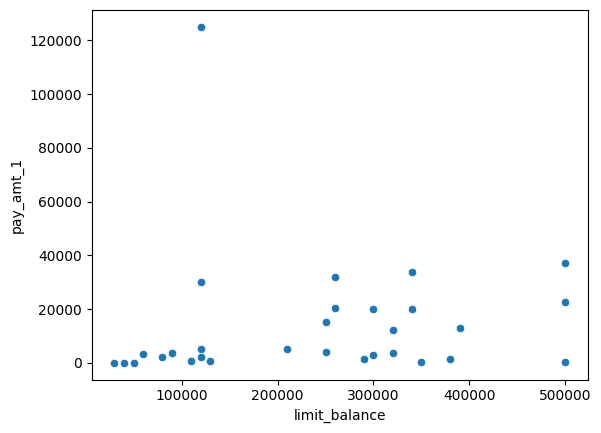

In [212]:
sns.scatterplot(false_negative_train_set, x='limit_balance', y='pay_amt_1');

Karakteristik umum yang dimiliki oleh nasabah yang masuk dalam False Negative di Training Set adalah mereka memiliki limit_balance yang besar jika kita bandingkan dengan pay_amt_1, 2, dan seterusnya.

#### False Negative di Testing Set setelah tuning

In [213]:
X_test_postive_negative = X_test.copy()
X_test_postive_negative.loc[:,'y'] = y_test
X_test_postive_negative['is_positive'] = np.where(X_test_postive_negative.y == 1, 'positive', 'negative')

In [214]:
pd.set_option('display.max_columns', len(X_test_postive_negative.columns) + 1)

In [215]:
false_negative_test_set = X_test_postive_negative[(X_test_postive_negative.y == 1) & (nb_new_y_hat_test == 0)]
false_negative_test_set.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,y,is_positive
2450,120000.0,1,1,2,28.0,-1.0,0.0,0.0,0.0,0.0,0.0,8922.0,43070.0,47023.0,53576.0,57529.0,61392.0,35000.0,5000.0,8000.0,5000.0,5000.0,4000.0,1,positive
1626,360000.0,2,2,1,35.0,2.0,2.0,2.0,2.0,0.0,0.0,360996.0,370722.0,380523.0,372735.0,290210.0,290551.0,16500.0,16500.0,6.0,10306.0,10876.0,10323.0,1,positive
1489,210000.0,2,2,1,37.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,22908.0,32513.0,6192.0,2885.0,8419.0,2810.0,32513.0,9.0,8.0,8444.0,3118.0,0.0,1,positive
2058,180000.0,2,1,2,31.0,4.0,4.0,4.0,3.0,2.0,2.0,83020.0,84654.0,82852.0,81162.0,79958.0,178148.0,3500.0,0.0,0.0,0.0,100000.0,0.0,1,positive
2429,200000.0,1,2,1,47.0,-1.0,-1.0,0.0,0.0,0.0,0.0,42114.0,227075.0,217016.0,200316.0,169815.0,88071.0,235728.0,10000.0,5210.0,4009.0,3186.0,55152.0,1,positive


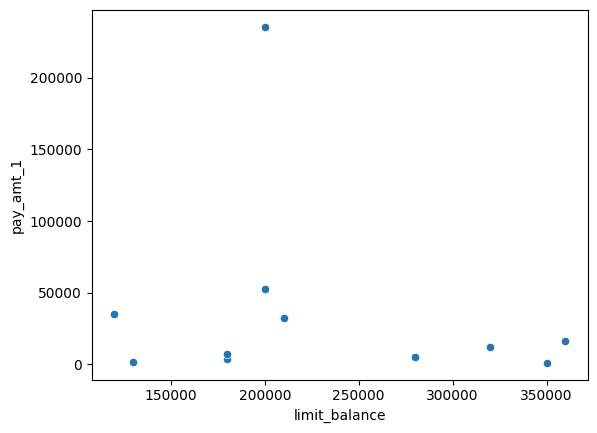

In [216]:
sns.scatterplot(false_negative_test_set, x='limit_balance', y='pay_amt_1');

Sama seperti di Training Set, pada Testing Set nasabah yang masuk dalam False Negative juga memiliki limit_balance yang sangat besar jika dibandingkan dengan pay_amt_1, 2, dan seterusnya.

## Kelebihan dan Kelemahan Model Naive Bayes

Kelebihan:  
* Dapat melakukan generalisasi dari Training Set ke Test Set  
* Bisa menekan jumlah False Negative dengan sangat baik

Kelemahan:
* Jika kita mencoba lebih menekan jumlah False Negative, jumlah False Positive bertambah banyak.
* Score Recall dari Training set dan Testing set masih beda, walaupun sedikit.

## Model Improvement

* Bisa meningkatkan nilai precision tanpa menurunkan nilai recall dari 90. Melakukan tranformasi outliers di features pay_amt_1, pay_amt_2, dan seterusnya dengan Winsorizing membantu nilai precision meningkat namun menurunkan nilai recall kurang dari 90.  
* Untuk meningkatkan score recall dan menemukan score precision yang maksimal, kita lebih baik melakukan hyperparameter tuning dari pada melakukan transformasi outliers dengan winsorization.
* Mencoba untuk mengubah threshold probability yang menentukan pada tingkat probability berapa model akan memastikan samples itu default atau tidak.

>---

# Conceptual Problems

1. Criterion adalah sebuah fungsi atau parameter di decision tree yang digunakan untuk mengukur kualitas split yang decision tree lakukan. Hal tersebut dilakukan untuk mencari split yang optimal. Decision tree akan melakukan split pada features berdasarkan purity yang dihitung oleh criterion. Beberapa criteria yang sudah kita ketahui adalah gini dan entropy. Criterion yang kita pakai pada kasus ini adalah criterion default dari sklearn yaitu gini. Gini impuruty akan mengukur derajat kemungkinan (probability) bahwa feature tertentu salah diklasifikasikan. Gini impurity adalah antara 0 dan 1. Semakin rendah nilai gini semakin bagus pula nilai splitnya.

source :  
* https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d#:~:text=criterion%20%3A%20This%20parameter%20determines%20how,is%20set%20to%20%E2%80%9Cbest%E2%80%9D.
* https://quantdare.com/decision-trees-gini-vs-entropy/
* https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263

2. Pruning adalah sebuah teknik yang dapat digunakan di tree-based models untuk menghindari overfitting dan menghindari mendapatkan akurasi yang jelek saat testing model. Pruning akan melakukan penghapusan sub-nodes jika hal tersebut dapat memperbaiki classification rates di data validation. Pruning akan menghindari tree kita terlalu dalam (banyak cabang dan panjang) (overfit). Pruning dapat dibagi jadi 2 tipe, yaitu pre dan post pruning.

source :  
* https://www.datacamp.com/tutorial/decision-trees-R
* https://developers.google.com/machine-learning/decision-forests/overfitting-and-pruning
* https://medium.com/mlearning-ai/pruning-in-decision-trees-4cfa10a36523

3. k yang kecil dapat menyebabkan model kita salah dalam melakukan klasifikasi karena noise dan k yang besar memiliki biaya computational yang tinggi dan dapat menyebabkan model kita biased. Untuk mendapatkan k yang optimal kita bisa melakukan:  
* k berupa angka odd (hal ini bertujuan untuk menghindari hasil voting tie)
* kita juga bisa mencoba banyak k value dan dilakukan dengan cross validation untuk mengetahui meannya
* kita juga bisa menggunakan sqrt(N)/2
* atau juga bisa elbow method.

source:  
* https://stackoverflow.com/questions/11568897/value-of-k-in-k-nearest-neighbor-algorithm
* https://towardsdatascience.com/why-does-increasing-k-decrease-variance-in-knn-9ed6de2f5061
* https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e
* https://www.listendata.com/2017/12/k-nearest-neighbor-step-by-step-tutorial.html
* https://www.quora.com/How-can-I-choose-the-best-K-in-KNN-K-nearest-neighbour-classification

4. Cross Validation adalah sebuah metode yang dapat digunakan untuk melihat seberapa efficient model kita melakukan learning atau traning menggunakan dataset training sebelum kita dapat menggunakan modelnya untuk melakukan prediksi data yang belum pernah model lihat atau dataset testing. Cross validation sering dibilang memiliki low bias karena cross validation akan membagi dataset training menjadi k samples dan ditujukan agar model dapat melakukan generalisasi lebih baik dibanding dengan hanya langsung melakukan training model (satu kali) dengan semua samples yang ada di training set. Cross validation digunakan untuk melihat sebarapa bagus model kita bekerja secara general menggunakan training set. Cross validation bisa digunakan untuk membandingkan model mana yang paling bagus dengan membandingkan nilai mean dari cross_val_score.

source:  
* https://machinelearningmastery.com/k-fold-cross-validation/
* https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right

5.  
* Precision akan memberi tahu kita seberapa banyak atau besar dari semua samples yang terprediksi positive beneran positive. (TP/(FP + TP)  
* Recall akan memberi tahu kita seberapa banyak atau besar samples yang beneran positive kita prediksi dengan benar (TP/(FN + TP).  
* F1-score adalah sebuah angka yang dapat menyimpulkan dua angka yaitu recall dan precision sebagai satu angka.  
* Accuracy adalah sebuah ratio antara prediksi kita yang benar (TP + TN) dibandingkan dengan seluruh samples (TP + FN + TN + FP). Nilai akurasi memberitahu kita seberapa banyak prediksi kita yang benar dari keseluruhan samples.  

When are they best used:  
* Kita akan menggunakan precision ketika kasus yang kita kerjakan menginginkan kita untuk menekan angka false positive, dan kasus kita tidak mempermasalahkan kita memiliki jumlah false negative lebih banyak.
* Recall adalah kebalikan dari precision. Kita akan menggunakan recall ketika kasus kita menganggap false negative yang banyak akan membuat mereka rugi yang mana angka ini perlu mereka tekan, dan tidak terlalu mempermasalahkan memiliki jumlah false positive lebih banyak.  
* F1 score akan kita gunakan ketika kasus kita ingin menekan false positive dan false negative.
* Accuracy adalah angka yang tidak memberikan insights sebagus precision, recall, dan f1 score. Accuracy hanya dapat digunakan sebagai salah satu indikator yang kita lihat ketika kita memiliki data yang balanced. Walaupun balanced, masih ada metric yang lebih bagus untuk dipakai evaluasi dibandingkan akurasi.  


source:  
* https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/  
* https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
* https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
* https://towardsdatascience.com/performance-metrics-confusion-matrix-precision-recall-and-f1-score-a8fe076a2262

When are they best used sources:  
* https://www.quora.com/When-is-precision-more-important-over-recall

use cases source:  
* https://datascience.stackexchange.com/questions/30881/when-is-precision-more-important-over-recall

>---

# Model Inference

In [217]:
with open('model_infer.pkl', 'wb') as file_1:
    pickle.dump(nb_new, file_1)

with open('scaler_infer.pkl', 'wb') as file_2:
    pickle.dump(scaler, file_2)

with open('cat_selector_infer.pkl', 'wb') as file_4:
    pickle.dump(cat_selector, file_4)

with open('num_selector_infer.pkl', 'wb') as file_5:
    pickle.dump(num_selector, file_5)

with open('num_cols_list_infer.txt', 'w') as file_6:
    json.dump(num_columns_selected_list, file_6)

with open('cat_cols_list_infer.txt', 'w') as file_7:
    json.dump(cat_columns_selected_list, file_7)

>---

# Overall Analysis (Kesimpulan)

Pada saat kita melakukan proses EDA kita sudah melihat bahwa limit_balance dan apakah nasabah terlambat bayar dan berapa lama keterlambatannya dengan jelas membedakan nasabah yang tidak default dan yang default. Features lainnya secara visual tidak bisa membedakan apakah nasabah defaul atau tidak.  

Namun pada features selection, dari features pay_ (nunggak atau nggak dan berapa lama) hanya feature pay_0 yang terpilih (yang memberikan nilai recall optimal) dan dari sekian numerical features hanya features pay_amt_ dan limit_balance yang terpilih yang mana limit balance memiliki score sanga besar dibanding dengan features lain.  
Hal tersebut ikut membuktikan bahwa limit balance dan keterlambatan membayar dapat membedakan apakah nasabah default atau tidak.

<!-- Sedangkan saat kita melakukan features ranking yang dihasilkan dari model paling optimal yang kita dapat dengan menggunakan permutation_importance rangking teratas di train set adalah pay_0 dan limit_balance dan ranking teratas di test set adalah pay_amt_ dan limit_balance.
Hal ini juga membuktikan bahwa keterlambatan membayar dan limit_balance credit card nasabah dapat menentukan apakah mereka default atau tidak.   -->

Dari tujuh model yang sudah kita coba dengan cross validation, kita memperoleh model yang dapat menghasilkan performa sangat baik, dengan score Recall lebih dari 90%, yaitu Naive Bayes. Model kita ini dapat menekan jumlah False Negative dengan sangat baik. Performa baik ini juga diperoleh pada unseen data (Testing Set). Hal tersebut menunjukkan bahwa model naive bayes dapat melakukan generalisasi ke unseen data dengan sangat baik. 

Setelah dilakukannya hyperparameter tuning pada model naive bayes, kita memperoleh score recall yang meningkat pada Training Set dan Testing Set. Model naive bayes ini juga tidak kehilangan score precision yang banyak. Hal tersebut bisa disebut kita memiliki cost kecil untuk meningkatkan score Recall atau menekan jumlah False Negative.

Dengan kita mendapatkan model naive bayes yang dapat bekerja sangat baik pada unseen data, kita atau penyedia kartu kredit dapat melakukan prediksi apakah calon nasabah kita di kemudian hari akan mengalami default atau tidak. Hal ini diharapkan dapat menurunkan biaya kerugian yang kita dapat karena terjadi default pada nasabah kita. Model ini juga diharapkan bisa menjadi proses pertama untuk memfilter calon nasabah mana yang kartu kreditnya bisa langsung diproses. Model ini juga bisa dikembangkan untuk bisa memfilter calon nasabah berdasarkan probabilitynya, yang mana kita dapat mempertimbagkan calon nasabah yang tidak lolos model (diprediksi default) tapi memiliki probability yang mendekati bahwa mereka tidak default.

<!-- Hasil model naive bayes berhasil memenuhi objectives yang sudah ditetapkan dengan recall yang melebihi 90% dan dapat melakukan generalisasi ke testing set dengan baik. Hal ini sangat penting untuk model kita dapat digunakan di real works yang dilakukan perusahaan penyedia kartu kredit. -->